

<span style="font-size: 32px; color: gray; font-weight: bold;">Projet 7 : Implémentez un modèle de scoring</span>
    

In [1]:
import pkg_resources

packages = [
    'flask',
    'joblib',
    'imbalanced-learn',
    'xgboost',
    'numpy',
    'pandas',
    'scikit-learn',
    'shap','streamlit','requests','plotly', 'xgboost', 'shap', 
]

with open('requirements.txt', 'w') as f:
    for package in packages:
        version = pkg_resources.get_distribution(package).version
        f.write(f"{package}=={version}\n")

In [2]:
from platform import python_version
print(python_version())

3.11.5


In [3]:
#pd.set_option('display.max_columns',None)

# Partie 1 : Preprocessing and analyse

Pour ce projet, je suis data scientist pour une entreprise qui propose des crédits. L'entreprise souhaite développer un modèle de scoring de la probabilité de défaut du client et l'associer à un tableau de bord interactif afin que les responsables de la relation client puissent expliquer avec la plus grande transparence les décisions d'octroi ou non d'un crédit.


In [4]:
import os
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
path.append('./')
#import project_fonctions as pf

***Importation Dataframe***

In [5]:
PATH='data/'
print('liste des fichier:')
display(os.listdir(PATH))

liste des fichier:


['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [6]:
application_test = pd.read_csv(PATH +'/application_test.csv ', encoding='iso-8859-1')
application_train = pd.read_csv(PATH +'/application_train.csv', encoding='iso-8859-1')
bureau = pd.read_csv(PATH +'/bureau.csv ', encoding='iso-8859-1')
bureau_balance = pd.read_csv(PATH +'/bureau_balance.csv ', encoding='iso-8859-1')
credit_card_balance = pd.read_csv(PATH +'/credit_card_balance.csv ', encoding='iso-8859-1')
HomeCredit_columns_description = pd.read_csv(PATH +'/HomeCredit_columns_description.csv ', encoding='iso-8859-1')
installments_payments = pd.read_csv(PATH +'/installments_payments.csv ', encoding='iso-8859-1')
POS_CASH_balance = pd.read_csv(PATH +'/POS_CASH_balance.csv ', encoding='iso-8859-1')
previous_application = pd.read_csv(PATH +'/previous_application.csv ', encoding='iso-8859-1')
sample_submission = pd.read_csv(PATH +'/sample_submission.csv ', encoding='iso-8859-1')

Il y a un total de 9 fichiers : 1 fichier principal pour l'entraînement (avec la cible) 1 fichier principal pour le test (sans la cible), 1 fichier de description, et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

- application_{train|test}.csv

Il s’agit de la table principale, divisée en deux fichiers pour Entraîner (avec TARGET) et Test (sans TARGET).
Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

- bureau.csv

Tous les crédits antérieurs du client accordés par d’autres institutions financières qui ont été déclarés à l’agence d’évaluation du crédit (pour les clients qui ont un prêt dans notre échantillon).
Pour chaque prêt de notre échantillon, il y a autant de rangées que le nombre de crédits que le client avait dans le bureau de crédit avant la date de la demande.

- bureau_balance.csv

Soldes mensuels des crédits précédents dans le bureau de crédit.
Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit précédent signalé à l’agence d’évaluation du crédit – c’est-à-dire que le tableau comporte (#loans dans l’échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique observable pour les crédits précédents) lignes.

- POS_CASH_balance.csv

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit précédent en crédit immobilier (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c’est-à-dire que le tableau comporte (#loans dans l’échantillon * # de crédits précédents relatifs * # de mois au cours desquels nous avons un historique observable pour les crédits précédents) lignes.

- credit_card_balance.csv

Instantanés mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
Ce tableau comporte une ligne pour chaque mois d’historique de chaque crédit précédent en crédit immobilier (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c’est-à-dire que le tableau comporte (#loans dans l’échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

- previous_application.csv

Toutes les demandes précédentes de prêts Home Credit des clients qui ont des prêts dans notre échantillon.
Il y a une rangée pour chaque demande antérieure liée aux prêts dans notre échantillon de données.

- installments_payments.csv

Historique des remboursements des crédits précédemment décaissés dans le crédit à l’habitation liés aux prêts de notre échantillon.
Il y a a) une rangée pour chaque paiement effectué plus b) une rangée pour chaque paiement manqué.
Une ligne équivaut à un paiement d’une mensualité OU à une mensualité correspondant à un paiement d’un précédent crédit Home Credit lié à des prêts dans notre échantillon.

- HomeCredit_columns_description.csv

Ce fichier contient les descriptions des colonnes des différents fichiers de données.

In [7]:
def data_describe(folder):
    # Initialisation de la table comparative
    comparative_table = pd.DataFrame(columns=['Rows', 'Columns', '%NaN', '%Duplicate', 
                                              'object_dtype', 'float_dtype', 'int_dtype', 
                                              'bool_dtype', 'MB_Memory'])
    
    # Parcourir les fichiers dans le dossier
    for file in os.listdir(folder):
        if file.endswith('.csv'):  # Assurez-vous de traiter uniquement les fichiers CSV
            file_path = os.path.join(folder, file)
            try:
                df = pd.read_csv(file_path)
            except UnicodeDecodeError:
                continue
            
            # Calcul des statistiques
            rows = df.shape[0]
            columns = df.shape[1]
            nan_percentage = df.isna().mean().mean() * 100
            duplicate_percentage = df.duplicated().mean() * 100
            object_dtype = (df.dtypes == 'object').sum()
            float_dtype = (df.dtypes == 'float').sum()
            int_dtype = (df.dtypes == 'int').sum()
            bool_dtype = (df.dtypes == 'bool').sum()
            memory_usage = df.memory_usage(deep=True).sum() / (1024 ** 2)  # En Mo
            
            # Ajout des statistiques à la table comparative
            comparative_table.loc[file] = [rows, columns, nan_percentage, duplicate_percentage, 
                                           object_dtype, float_dtype, int_dtype, bool_dtype, memory_usage]
    
    return comparative_table

PATH = 'data/'
comparative_table = data_describe(PATH)
display(comparative_table)

,Rows,Columns,%NaN,%Duplicate,object_dtype,float_dtype,int_dtype,bool_dtype,MB_Memory
application_test.csv,48744.0,121.0,23.811687,0.0,16.0,65.0,0.0,0.0,84.735026
application_train.csv,307511.0,122.0,24.395942,0.0,16.0,65.0,0.0,0.0,536.691602
bureau.csv,1716428.0,17.0,13.502552,0.0,3.0,8.0,0.0,0.0,512.110762
bureau_balance.csv,27299925.0,3.0,0.000000,0.0,1.0,0.0,0.0,0.0,1926.607687
credit_card_balance.csv,3840312.0,23.0,6.654074,0.0,1.0,15.0,0.0,0.0,875.687668
installments_payments.csv,13605401.0,8.0,0.005338,0.0,0.0,5.0,0.0,0.0,830.407902
POS_CASH_balance.csv,10001358.0,8.0,0.065189,0.0,1.0,2.0,0.0,0.0,1137.250179
previous_application.csv,1670214.0,37.0,17.976877,0.0,16.0,15.0,0.0,0.0,1900.631667
sample_submission.csv,48744.0,2.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.743900


***application_test***

In [8]:
application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
application_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

***application_train***

In [10]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

***bureau***

In [12]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [13]:
bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


***bureau_balance***

In [14]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [15]:
bureau_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


***credit_card_balance***

In [16]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [17]:
credit_card_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

***HomeCredit_columns_description***

In [18]:
HomeCredit_columns_description.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [19]:
HomeCredit_columns_description.shape

(219, 5)

In [20]:
HomeCredit_columns_description.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [21]:
filtered_df=HomeCredit_columns_description[HomeCredit_columns_description['Row'] =='TARGET']
print(filtered_df[['Row', 'Description']].to_string(index=False))

   Row                                                                                                                                                                                 Description
TARGET Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)


***installments_payments***

In [22]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [23]:
installments_payments.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


***POS_CASH_balance***

In [24]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [25]:
POS_CASH_balance.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


***previous_application***

In [26]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

***sample_submission***

In [28]:
sample_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


In [29]:
sample_submission.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


## ANALYSE EXPLORATOIR

+ Les valeurs manquantes
+ Les anomalies éventuelles
+ La distribution de certains features d'intérêt
+ Les corrélations

### Les valeurs manquantes

In [30]:
def afficher_pourcentage_valeurs_manquantes(df, largeur=10, hauteur=8, nom='DataFrame'):
    # Calculer le nombre de valeurs manquantes et leur pourcentage
    valeurs_manquantes = df.isnull().sum()
    pourcentage_manquant = (valeurs_manquantes / len(df)) * 100
    
    # Créer un DataFrame pour les valeurs manquantes
    df_manquant = pd.DataFrame({'Valeurs Manquantes': valeurs_manquantes, 'Pourcentage': pourcentage_manquant})
    
    # Filtrer les colonnes avec des valeurs manquantes
    df_manquant = df_manquant[df_manquant['Valeurs Manquantes'] > 0]
    
    # Trier les colonnes par pourcentage de valeurs manquantes
    df_manquant = df_manquant.sort_values(by='Pourcentage', ascending=False)
    
    # Créer un graphique en barres horizontales
    plt.figure(figsize=(largeur, hauteur))
    sns.barplot(x=df_manquant['Pourcentage'], y=df_manquant.index, palette='viridis')
    plt.xlabel('Pourcentage de valeurs manquantes', fontsize=20)
    plt.ylabel('Colonnes', fontsize=20)
    plt.show()

***application_test***

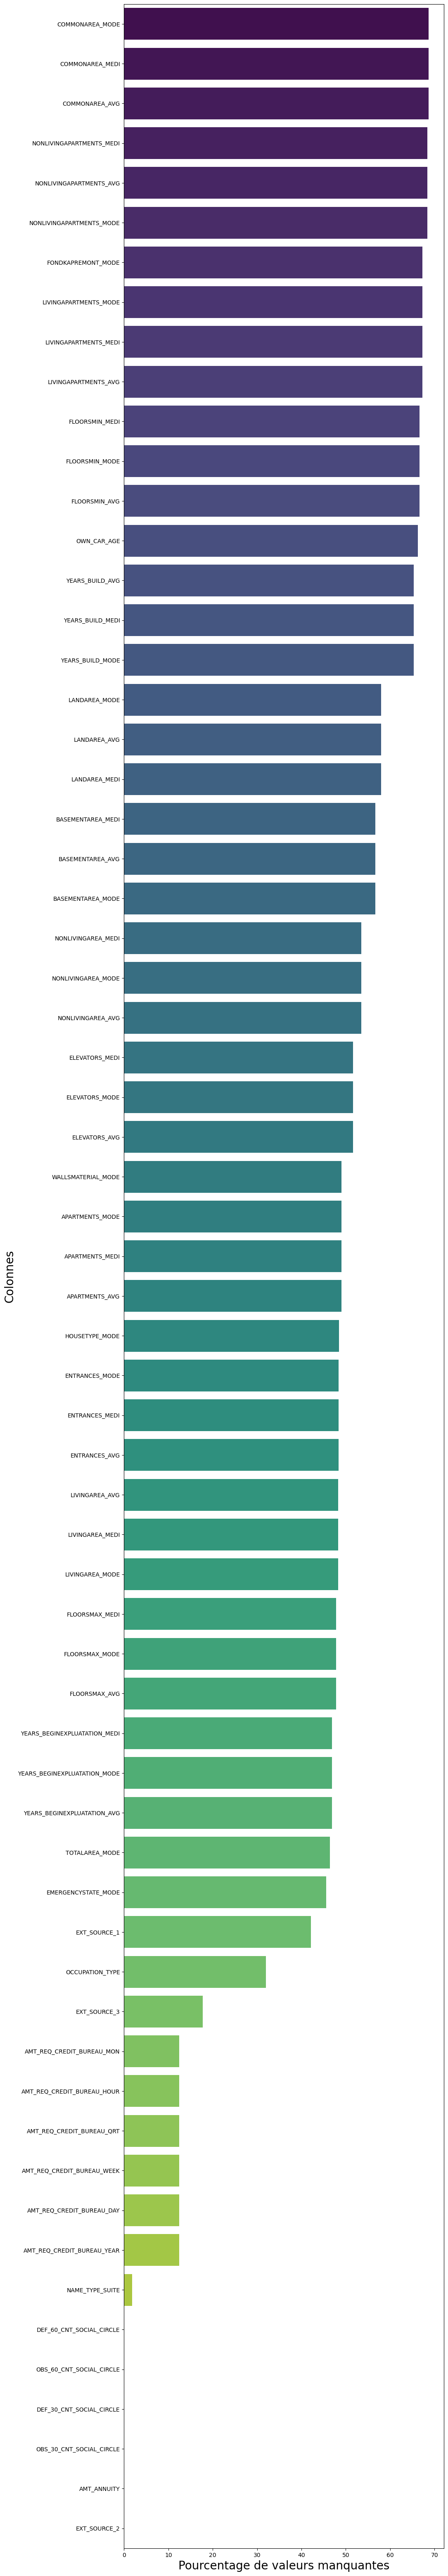

In [31]:
afficher_pourcentage_valeurs_manquantes(application_test, largeur=10, hauteur=80, nom='application_test')

***application_train***

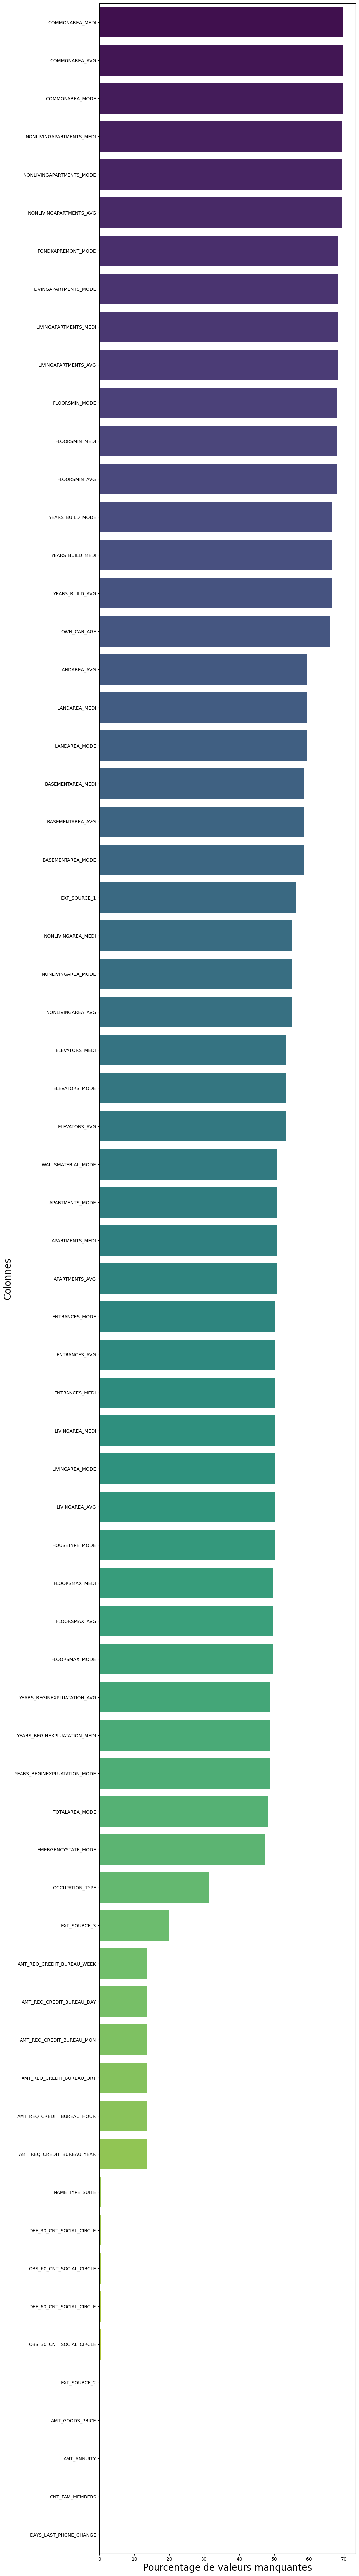

In [32]:
afficher_pourcentage_valeurs_manquantes(application_train, largeur=10, hauteur=100, nom='application_train')

***bureau***

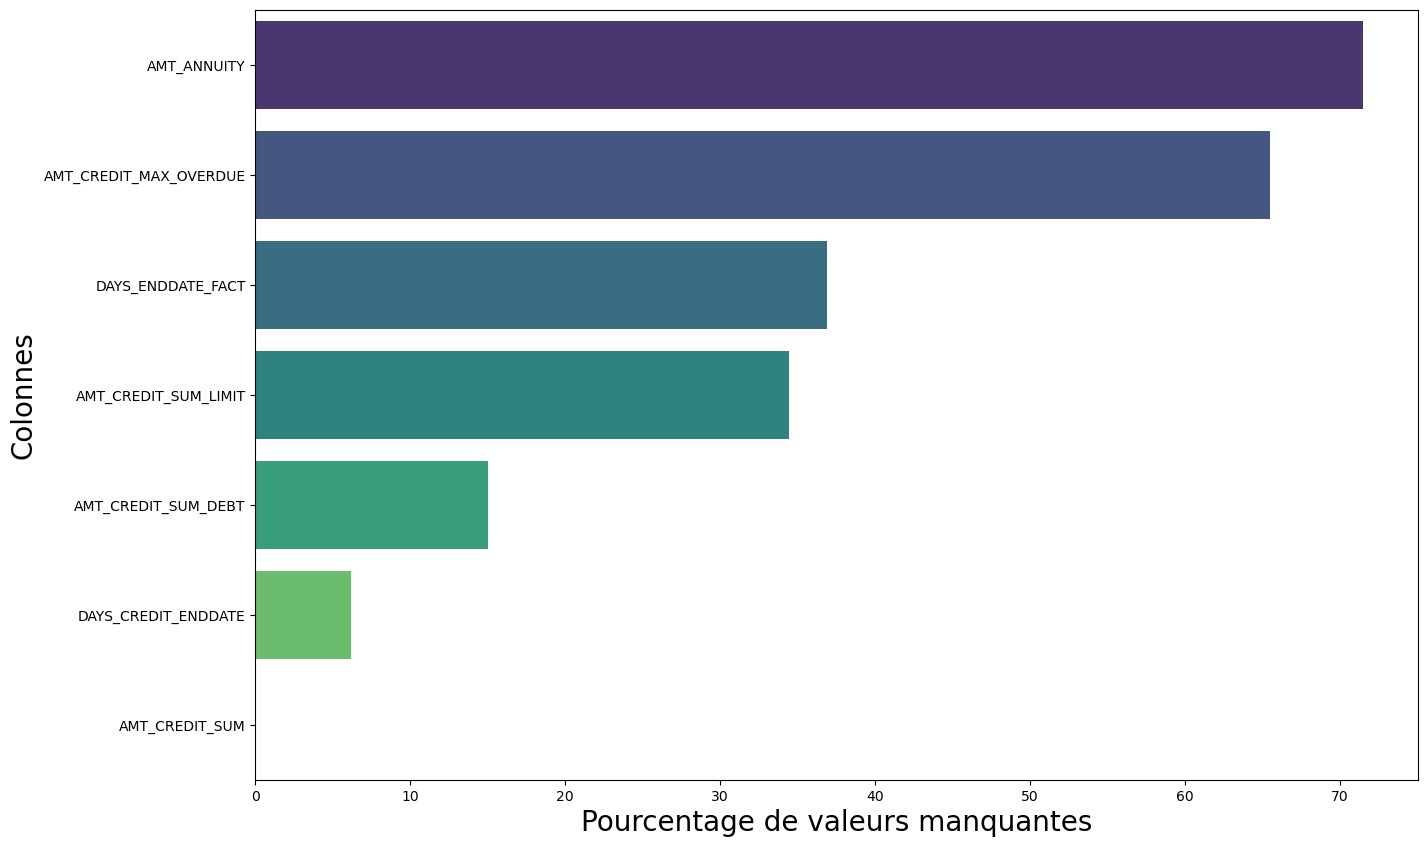

In [33]:
afficher_pourcentage_valeurs_manquantes(bureau, largeur=15, hauteur=10, nom='bureau')

***credit_card_balance***

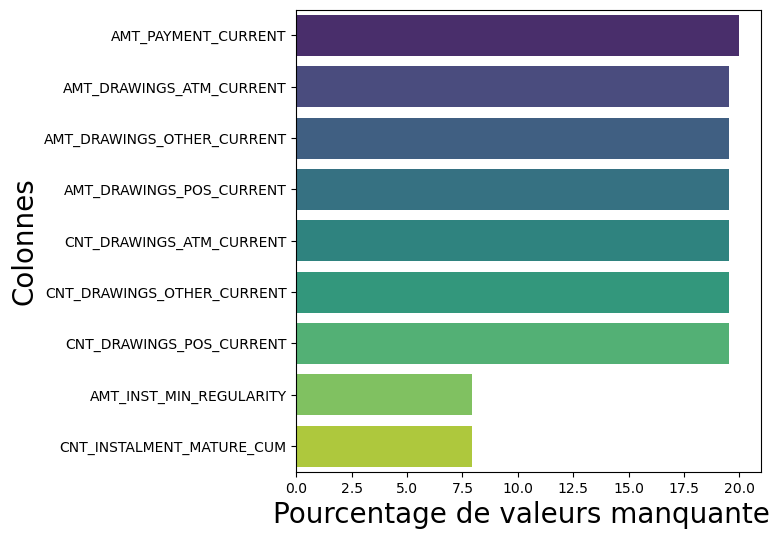

In [34]:
afficher_pourcentage_valeurs_manquantes(credit_card_balance, largeur=6, hauteur=6, nom='credit_card_balance')

***HomeCredit_columns_description***

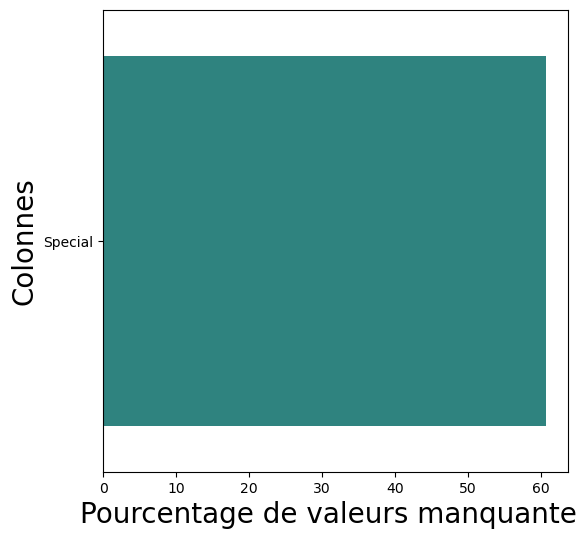

In [35]:
afficher_pourcentage_valeurs_manquantes(HomeCredit_columns_description, largeur=6, hauteur=6, nom='HomeCredit_columns_description')

***installments_payments***

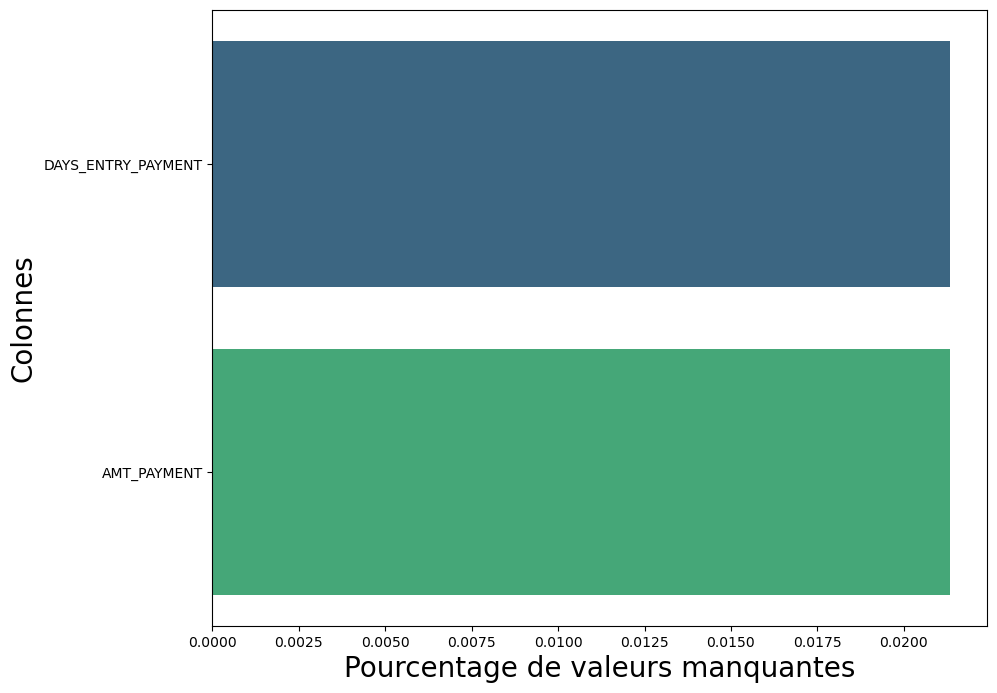

In [36]:
afficher_pourcentage_valeurs_manquantes(installments_payments, largeur=10, hauteur=8, nom='installments_payments')

***POS_CASH_balance***

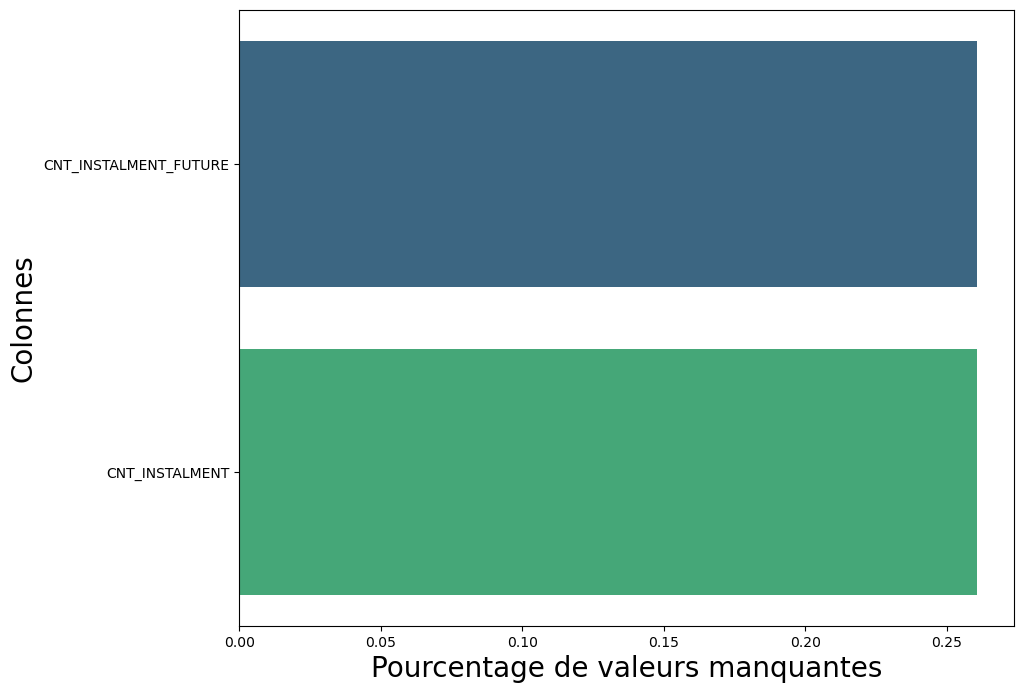

In [37]:
afficher_pourcentage_valeurs_manquantes(POS_CASH_balance, largeur=10, hauteur=8, nom='POS_CASH_balance')

***previous_application***

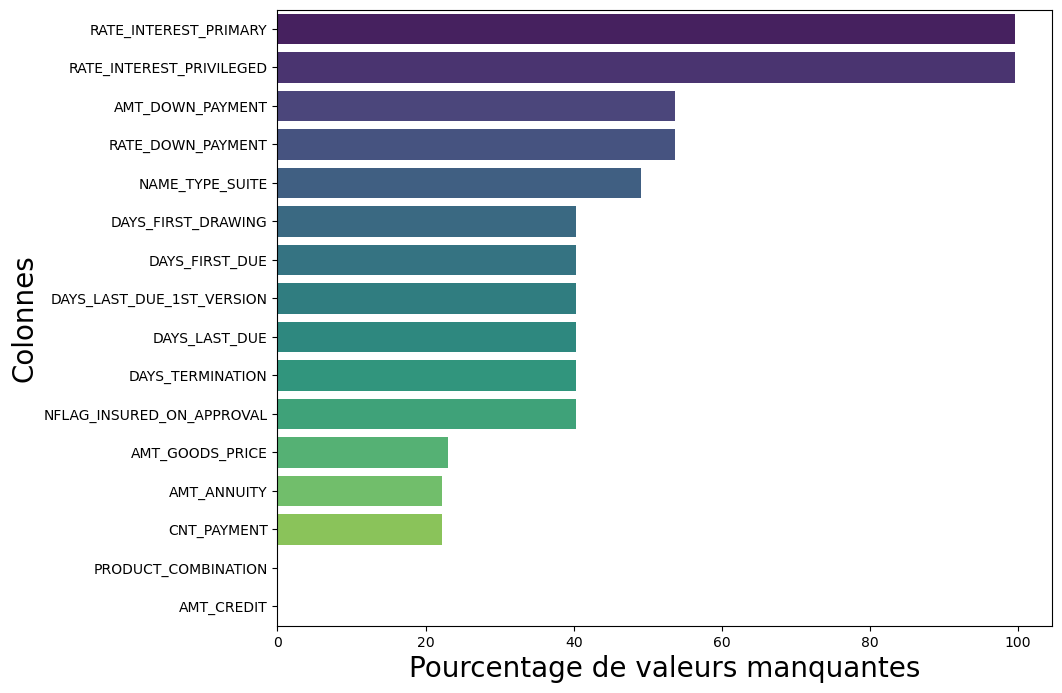

In [38]:
afficher_pourcentage_valeurs_manquantes(previous_application, largeur=10, hauteur=8, nom='previous_application')

### Outliers, valeurs atypiques, anormales


Un outlier peut être :

une valeur aberrante : c'est une valeur qui est manifestement fausse ;

une valeur atypique : c'est une valeur qui "sort du lot", mais pas forcément fausse.

In [39]:
def plot_boxplots(df, title, num_cols=3, figsize=(80, 80)):
    # Calculer le nombre de lignes nécessaires
    num_rows = (len(df.columns) + num_cols - 1) // num_cols

    # Créer une figure avec la taille spécifiée
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Aplatir le tableau des axes pour une itération facile
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        # Vérifier si la colonne est numérique
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.boxplot(y=df[col], ax=axes[i])
            axes[i].set_title(f'Boîte à moustaches de la colonne {col}')
            axes[i].set_ylabel(col)
        else:
            axes[i].set_visible(False)

    # Supprimer les sous-graphiques inutilisés
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

##### Valeurs aberrantes dans application_train

In [40]:
df_application_train=application_train[['TARGET','NAME_CONTRACT_TYPE','AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_GOODS_PRICE','DAYS_BIRTH','CNT_CHILDREN','DAYS_EMPLOYED','CODE_GENDER','FLAG_OWN_REALTY','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE','FLAG_OWN_CAR']]

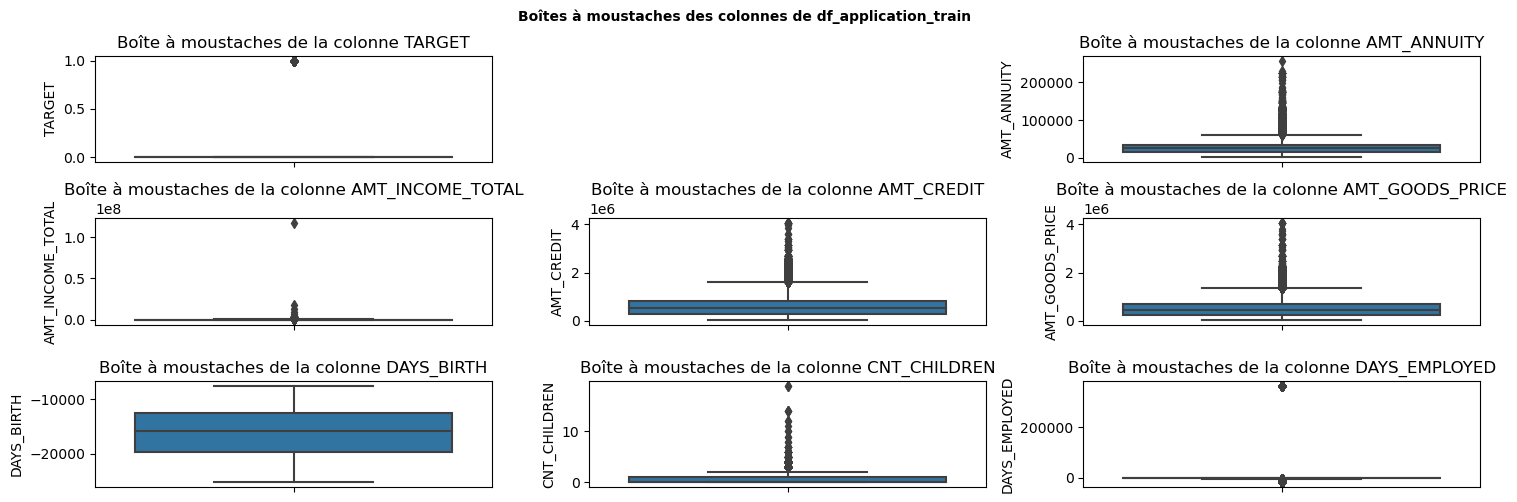

In [41]:
# Exemple d'utilisation
plot_boxplots(df_application_train, 'Boîtes à moustaches des colonnes de df_application_train', num_cols=3, figsize=(15, 10))

- AMT_ANNUITY, AMT_CREDIT, AMT_GOODS_PRICE, CNT_CHILDREN ont un certain nombre de valeurs aberrantes.

- AMT_INCOME_TOTAL a un grand nombre de valeurs aberrantes qui indiquent que quelques demandeurs de prêt ont un revenu élevé par rapport aux autres.

- DAYS_BIRTH n'a pas de valeurs aberrantes, ce qui signifie que les données disponibles sont fiables.

- DAYS_EMPLOYED a des valeurs aberrantes autour de 350000(jours), ce qui représente environ 958 ans, ce qui est impossible, donc c'est certainement une entrée incorrecte.

In [42]:
df_application_train.describe()

,TARGET,AMT_ANNUITY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_BIRTH,CNT_CHILDREN,DAYS_EMPLOYED
count,307511.000000,307499.000000,3.075110e+05,3.075110e+05,3.072330e+05,307511.000000,307511.000000,307511.000000
mean,0.080729,27108.573909,1.687979e+05,5.990260e+05,5.383962e+05,-16036.995067,0.417052,63815.045904
std,0.272419,14493.737315,2.371231e+05,4.024908e+05,3.694465e+05,4363.988632,0.722121,141275.766519
min,0.000000,1615.500000,2.565000e+04,4.500000e+04,4.050000e+04,-25229.000000,0.000000,-17912.000000
25%,0.000000,16524.000000,1.125000e+05,2.700000e+05,2.385000e+05,-19682.000000,0.000000,-2760.000000
50%,0.000000,24903.000000,1.471500e+05,5.135310e+05,4.500000e+05,-15750.000000,0.000000,-1213.000000
75%,0.000000,34596.000000,2.025000e+05,8.086500e+05,6.795000e+05,-12413.000000,1.000000,-289.000000
max,1.000000,258025.500000,1.170000e+08,4.050000e+06,4.050000e+06,-7489.000000,19.000000,365243.000000


DAYS_BIRTH	: Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons les multiplier par -1 et les diviser par le nombre de jours dans une année

In [43]:
(df_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

En moyenne, les clients ont 43 ans, le plus jeune a 20 ans et le plus âgé 69 ans. 50% des clients ont moins de 43 ans. Nous pouvons donc dire que l'étude est principalement axée sur les personnes d'une quarantaine d'années.

##### Valeurs aberrantes dans previous_applications

In [44]:
df_previous_application=previous_application[['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'SELLERPLACE_AREA', 'AMT_GOODS_PRICE','CNT_PAYMENT', 'DAYS_DECISION','CNT_PAYMENT']]

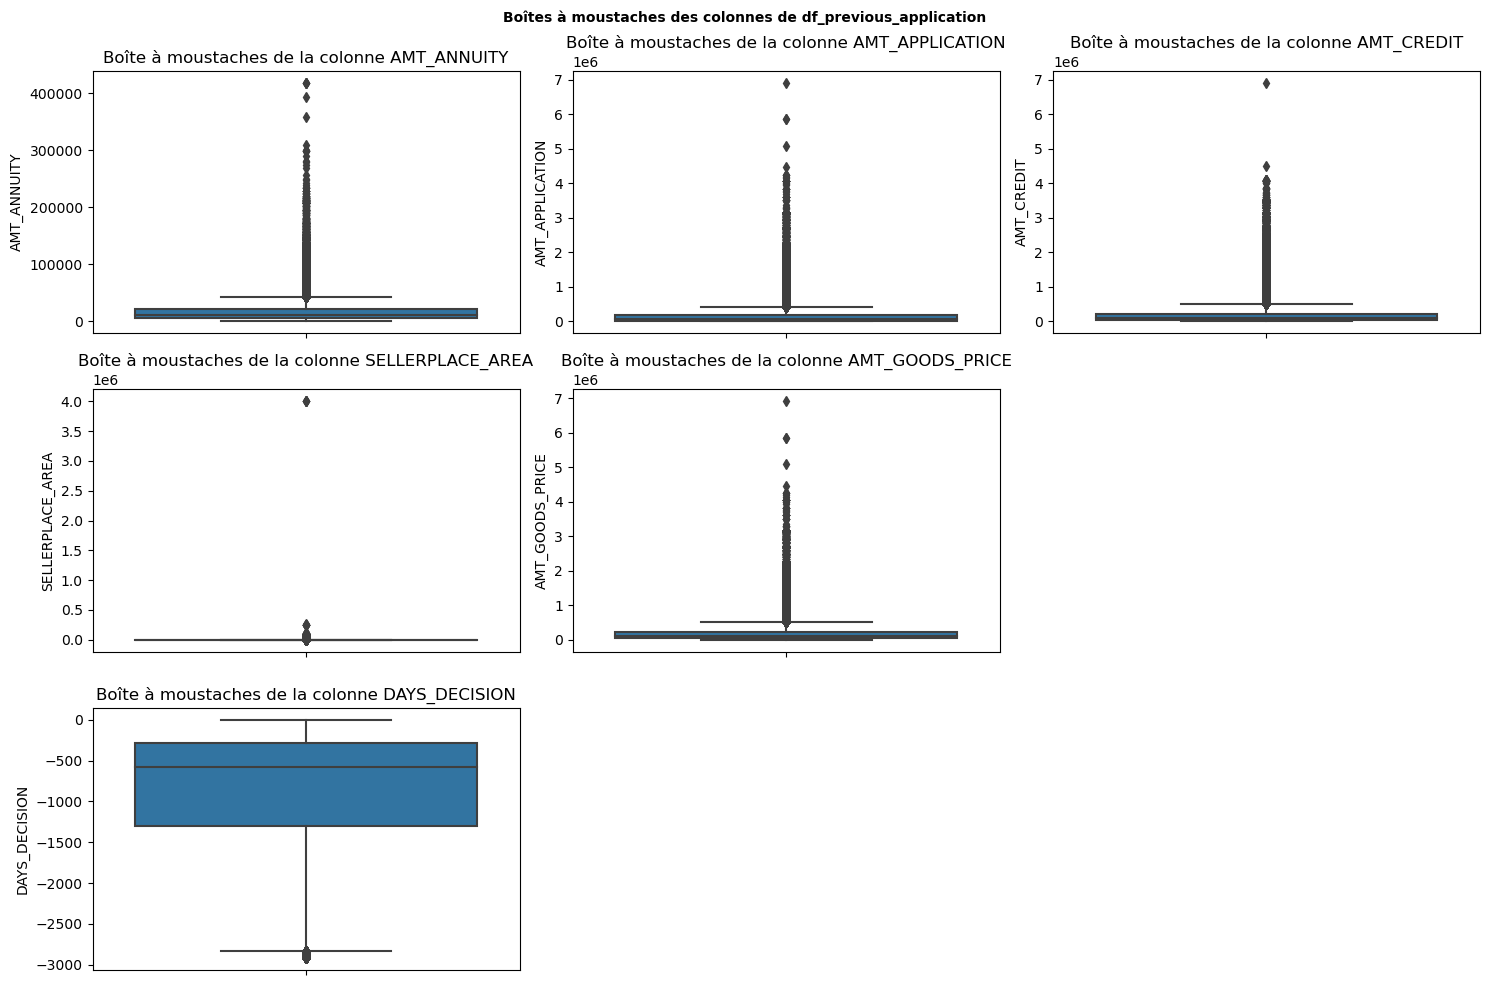

In [45]:
plot_boxplots(df_previous_application, 'Boîtes à moustaches des colonnes de df_previous_application', num_cols=3, figsize=(15, 10))

AMT_ANNUITY, AMT_APPLICATION, AMT_CREDIT, AMT_GOODS_PRICE, SELLERPLACE_AREA ont un nombre important de valeurs aberrantes.

CNT_PAYMENT a quelques valeurs aberrantes.

SK_ID_CURR est une colonne d'identification et donc aucune valeur aberrante.

DAYS_DECISION a un petit nombre de valeurs aberrantes, ce qui indique que les décisions relatives aux demandes précédentes ont été prises il y a longtemps.

In [46]:
df_previous_application.describe()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,SELLERPLACE_AREA,AMT_GOODS_PRICE,CNT_PAYMENT,DAYS_DECISION,CNT_PAYMENT
count,1.297979e+06,1.670214e+06,1.670213e+06,1.670214e+06,1.284699e+06,1.297984e+06,1.670214e+06,1.297984e+06
mean,1.595512e+04,1.752339e+05,1.961140e+05,3.139511e+02,2.278473e+05,1.605408e+01,-8.806797e+02,1.605408e+01
std,1.478214e+04,2.927798e+05,3.185746e+05,7.127443e+03,3.153966e+05,1.456729e+01,7.790997e+02,1.456729e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,0.000000e+00
25%,6.321780e+03,1.872000e+04,2.416050e+04,-1.000000e+00,5.084100e+04,6.000000e+00,-1.300000e+03,6.000000e+00
50%,1.125000e+04,7.104600e+04,8.054100e+04,3.000000e+00,1.123200e+05,1.200000e+01,-5.810000e+02,1.200000e+01
75%,2.065842e+04,1.803600e+05,2.164185e+05,8.200000e+01,2.340000e+05,2.400000e+01,-2.800000e+02,2.400000e+01
max,4.180581e+05,6.905160e+06,6.905160e+06,4.000000e+06,6.905160e+06,8.400000e+01,-1.000000e+00,8.400000e+01


### Distribution features

##### analyse univariée

Target :Statut de rembourcement du prêt

In [47]:
df_application_train['TARGET'].value_counts().reset_index()

,TARGET,count
0,0,282686
1,1,24825


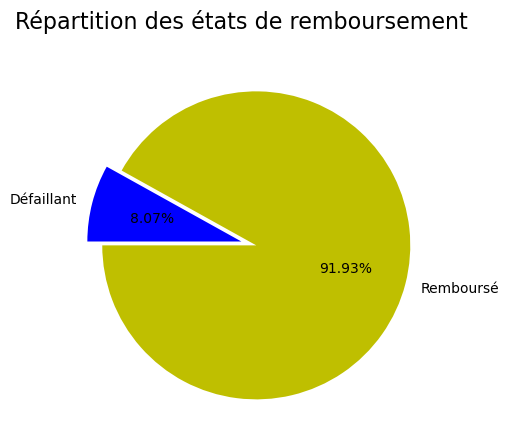

In [48]:
# Calculer la distribution des états de remboursement
credit_status_distribution = df_application_train['TARGET'].value_counts().reset_index()
credit_status_distribution.columns = ['categorie', 'TARGET']

# Créer le graphique en secteurs
plt.figure(figsize=(6, 5))
labels = ['Remboursé', 'Défaillant']
sizes = credit_status_distribution['TARGET']
colors = ['y', 'b']
explode = (0.1, 0)  # Séparer légèrement le premier secteur

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=180, explode=explode)
plt.title('Répartition des états de remboursement', fontsize=16, pad=15)
plt.show()

La TARGET est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

In [49]:
def univar_cat (df_application_train, feature,titre,ylog=False, label_rotation=False,horizontal_layout=True):
    temp=df_application_train[feature].value_counts()
    df1=pd.DataFrame({feature:temp.index,'Number of contracts':temp.values})
    cat_perc=df_application_train[[feature,'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc['TARGET'] = cat_perc['TARGET']*100
    cat_perc.sort_values(by='TARGET',ascending=False,inplace=True)
    if horizontal_layout:
        fig, (ax1,ax2)=plt.subplots(ncols=2, figsize=(12,5)) 
    else:
        fig, (ax1,ax2)=plt.subplots(nrows=2, figsize=(12,24))
    s=sns.countplot(ax=ax1,x=feature,data=df_application_train,hue='TARGET',order=cat_perc[feature],palette=['y','b'])
    ax1.set_title(titre,fontdict={'fontsize':15,'fontweight':'bold'})
    ax1.legend(['Remboursé','Défaillant'])
    ax1.set_yscale('log') 
    ax1.set_ylabel('count(log)',fontdict={'fontsize':15,'fontweight':'bold'}) 
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    s=sns.barplot(ax=ax2,x=feature,y='TARGET',order=cat_perc[feature],data=cat_perc,palette='Set2')
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=60)
    plt.ylabel("Pourcentage de défaillants[%]",fontsize=10)
    plt.tick_params(axis='both',which='major',labelsize=10)
    ax2.set_title(titre + "(%Défailliants)",fontdict={'fontsize':15,'fontweight':'bold'})
    plt.show() 

***NAME_CONTRACT_TYPE : Type de contrat****

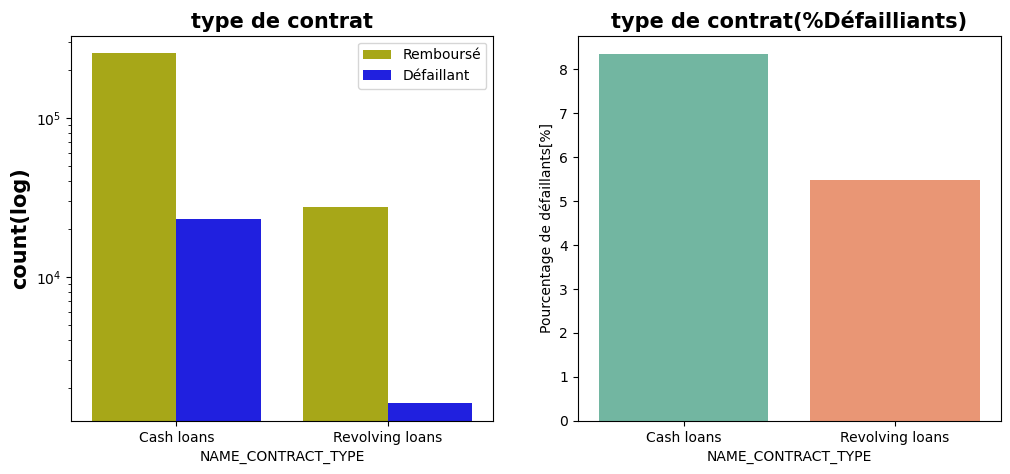

In [50]:
univar_cat (df_application_train,'NAME_CONTRACT_TYPE','type de contrat','type de contrat(% Défaillants)')

les prêts renouvelables ne représentent qu'une petite fraction (10 %) du nombre total de prêts ; dans le même temps, un plus grand nombre de prêts renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

***CODE_GENDER :Genre***

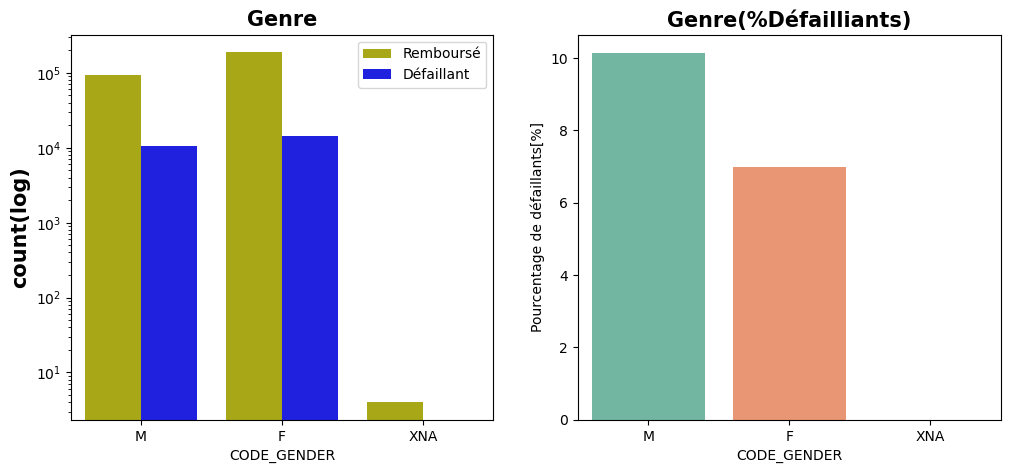

In [51]:
univar_cat (df_application_train,'CODE_GENDER','Genre')

Le nombre de clients féminins est presque le double du nombre de clients masculins. Sur la base du pourcentage de crédits en défaut, les hommes ont plus de chances de ne pas rembourser leurs prêts (~ 10 %), par rapport aux femmes (~ 7 %)

***FLAG_OWN_CAR : indication sur la possession d'un véhicule***

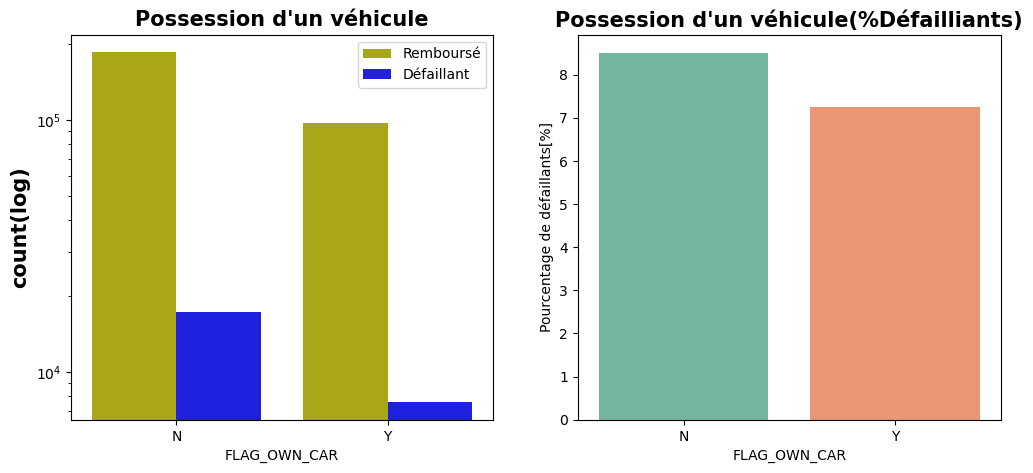

In [52]:
univar_cat (df_application_train, "FLAG_OWN_CAR" ,"Possession d'un véhicule") 

Les clients qui possèdent une voiture sont la moitié en nombre des clients qui ne possèdent pas de voiture. Mais sur la base du pourcentage de défaut, il n'y a pas de corrélation entre la possession d'une voiture et le remboursement du prêt car dans les deux cas, le pourcentage de défaut est presque le même.

***FLAG_OWN_REALTY : indication sur la possession d'un bien immobilier***

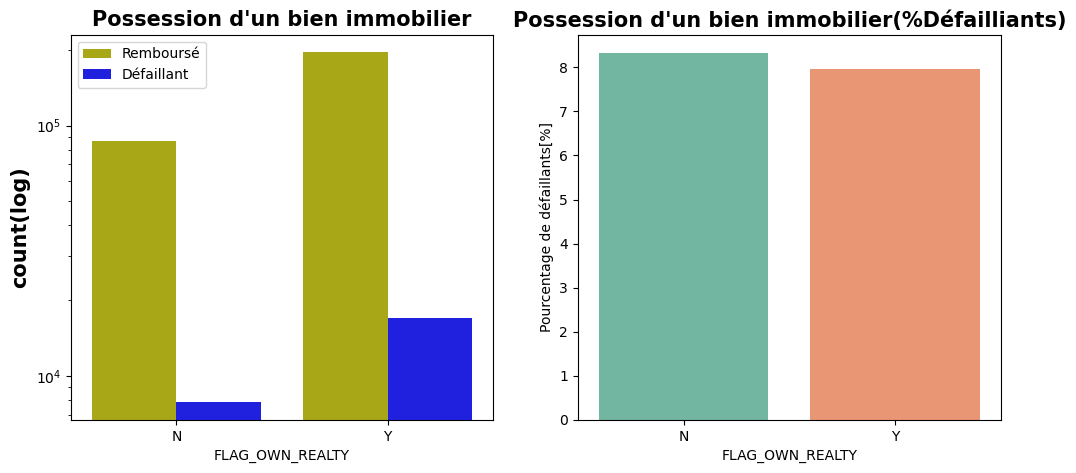

In [53]:
univar_cat (df_application_train,'FLAG_OWN_REALTY',"Possession d'un bien immobilier")

Les clients qui possèdent des biens immobiliers sont plus du double de ceux qui ne sont pas propriétaires. Mais le taux de défaut des deux catégories est à peu près le même (~8%). Ainsi, il n'y a pas de corrélation entre la possession d'un bien immobilier et le défaut de paiement du prêt.

***NAME_FAMILY_STATUS : status familial***

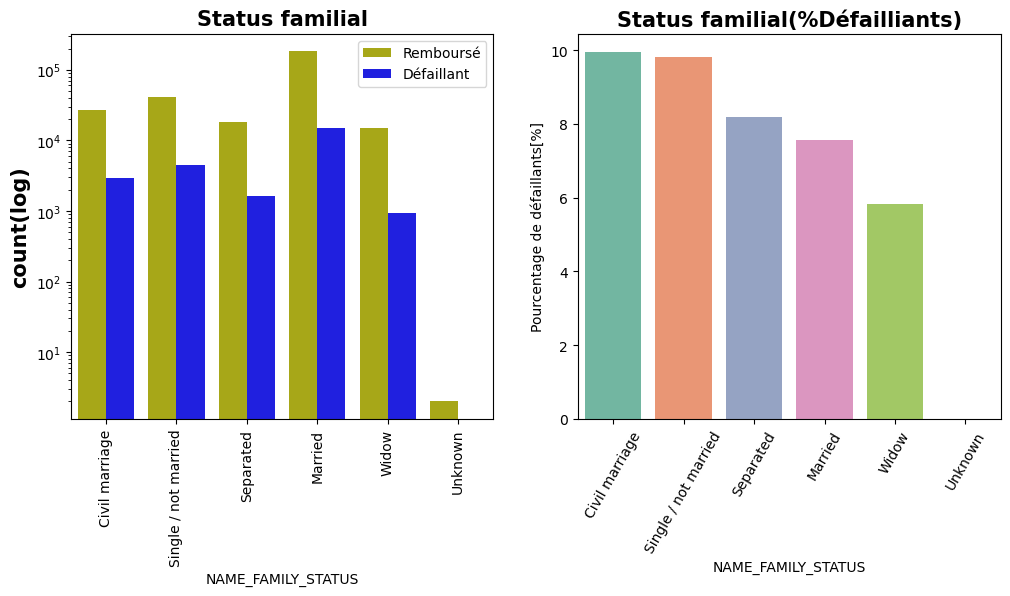

In [54]:
univar_cat (df_application_train,'NAME_FAMILY_STATUS','Status familial',True,True)

La plupart des personnes qui ont contracté un prêt sont mariées, suivies par les célibataires/non mariés et le mariage civil
En termes de pourcentage de non-remboursement de prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10 %), le statut de veuf(ve) eyant le plus faible taux de non-remboursement (l'exception étant inconnue).

***NAME_EDUCATION_TYPE : niveau d'éducation***

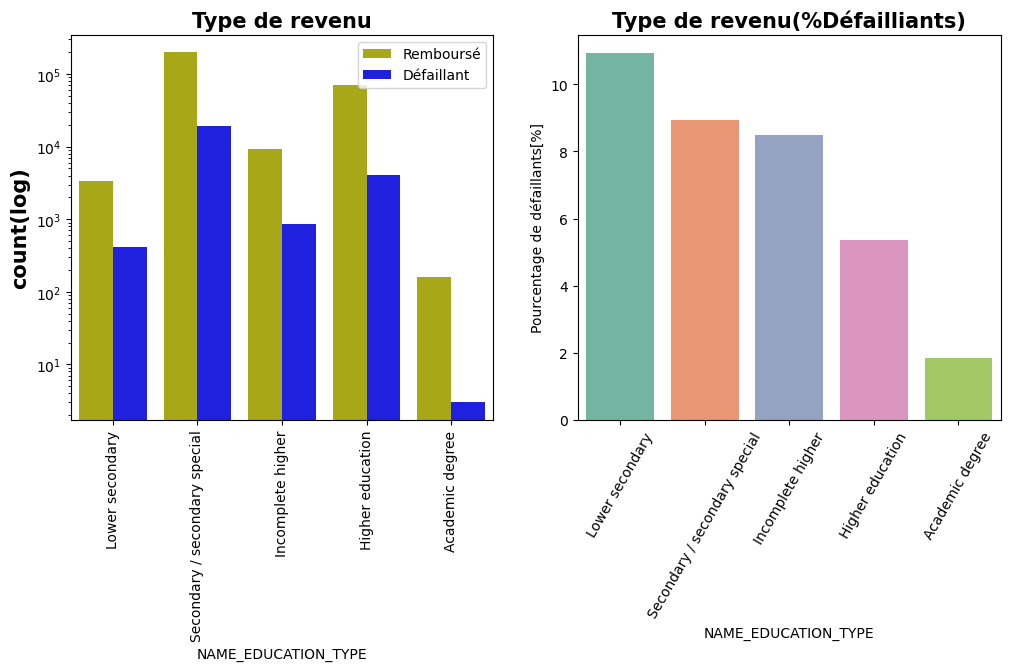

In [55]:
univar_cat (df_application_train,'NAME_EDUCATION_TYPE','Type de revenu',True,True)

La majorité des clients ont une éducation de niveau secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

***NAME_INCOME_TYPE : type de revenu***

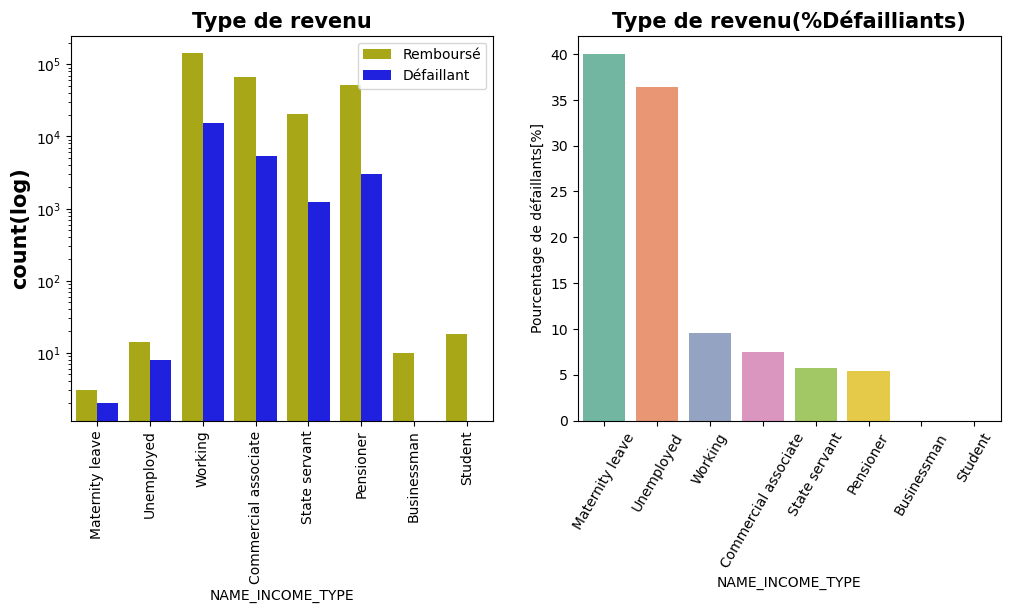

In [56]:
univar_cat (df_application_train,'NAME_INCOME_TYPE','Type de revenu',True,True)

La plupart des demandeurs de prêts ont pour type de revenu le travail, suivi par les associés commerciaux, les retraités et les fonctionnaires.
Les demandeurs ayant un revenu de type congé de maternité ont un taux de non-retour de près de 40 %, suivis par les chômeurs (37 %). Les autres types de revenus se situent en dessous de la moyenne de 10% de non remboursement des prêts.
Les étudiants et les hommes d'affaires, bien que moins nombreux, n'ont pas de cas de défaut de paiement. Ces deux catégories sont donc les plus sûres pour l'octroi de prêts.

***OCCUPATION_TYPE : type de profession***

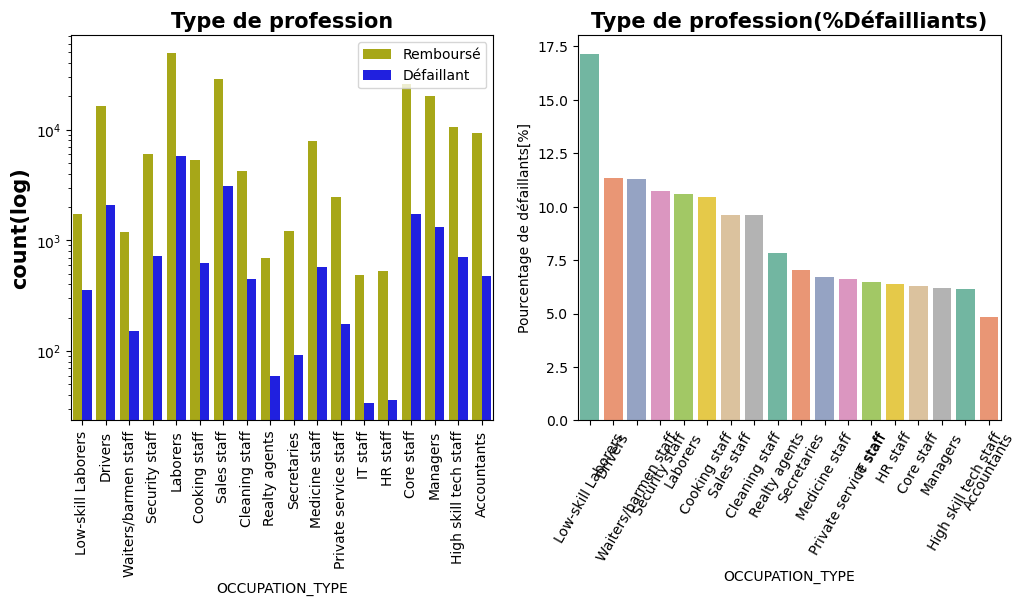

In [57]:
univar_cat (df_application_train,'OCCUPATION_TYPE','Type de profession',True,True)

La plupart des prêts sont contractés par des ouvriers, suivis par le personnel de vente. Les informaticiens sont ceux qui empruntent le moins.
La catégorie présentant le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivie des chauffeurs et des serveurs/barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

***CNT_CHILDREN : Nombre d'enfants***

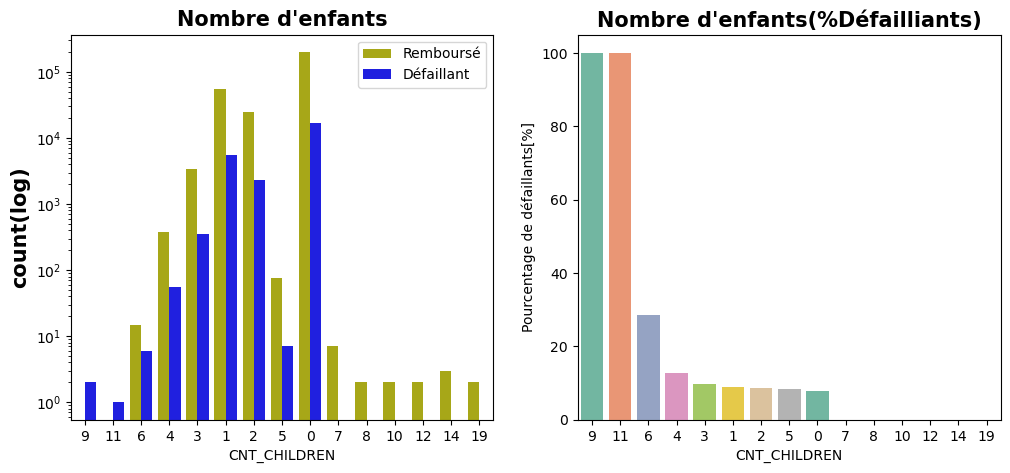

In [58]:
univar_cat (df_application_train,'CNT_CHILDREN',"Nombre d'enfants")

La plupart des demandeurs n'ont pas d'enfants

Très peu de clients ont plus de 3 enfants.

Les clients qui ont plus de 4 enfants ont un taux de défaillance très élevé, ceux ayant 9 et 11 enfants présentant un taux de défaillance de 100%.

***DAYS_EMPLOYED : Nombre de jours d'emploi***

C:\Users\--\AppData\Local\Temp\ipykernel_8656\669518339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['DAYS_EMPLOYED_BIN']=df_application_train['DAYS_EMPLOYED'] / 365


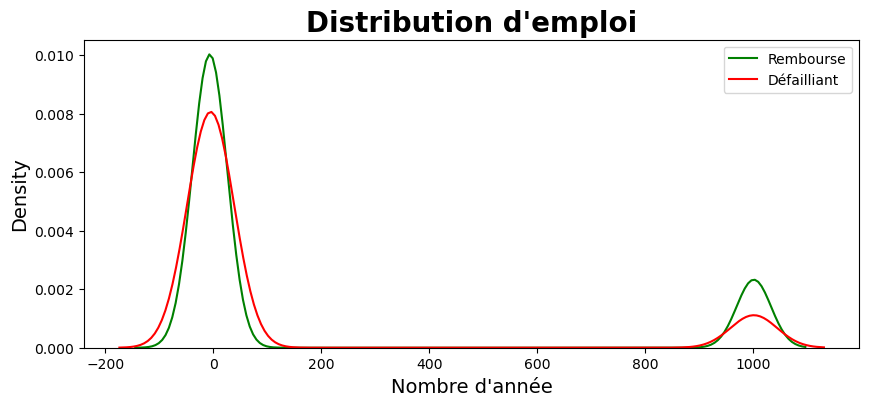

In [59]:
df_application_train['DAYS_EMPLOYED_BIN']=df_application_train['DAYS_EMPLOYED'] / 365
# convertit d’abord les jours en années pour obtenir l’âge.
plt.figure(figsize=(10,4))
sns.kdeplot(df_application_train[df_application_train['TARGET'] == 0]['DAYS_EMPLOYED_BIN'],label='Rembourse',color='g')
sns.kdeplot(df_application_train[df_application_train['TARGET'] == 1]['DAYS_EMPLOYED_BIN'],label='Défailliant',color='r')
plt.legend()
plt.xlabel("Nombre d'année",fontsize='14')
plt.ylabel('Density',fontsize='14')
plt.title("Distribution d'emploi",fontsize='20',fontweight='bold')
plt.show()

Ici avec cette analyse, on peut voir qu'il y a des données anormales car le maximun représente environ 100 ans de travail (ce qui est impossible).


In [60]:
df_application_train['YEARS_EMPLOYED_1']=df_application_train['DAYS_EMPLOYED'] // -365
bins = [0,5,10,20,30,40,50,60,float('inf')]
Labels = ['0-5','5-10', '10-20', '20-30', '30-40','40-50','50-60','60+']
df_application_train['YEARS_EMPLOYED_BINS']= pd.cut(df_application_train['YEARS_EMPLOYED_1'], bins=bins,labels=Labels, right=False)
df_application_train['YEARS_EMPLOYED_BINS'].value_counts(normalize=True)*100

C:\Users\--\AppData\Local\Temp\ipykernel_8656\2084164404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['YEARS_EMPLOYED_1']=df_application_train['DAYS_EMPLOYED'] // -365
C:\Users\--\AppData\Local\Temp\ipykernel_8656\2084164404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['YEARS_EMPLOYED_BINS']= pd.cut(df_application_train['YEARS_EMPLOYED_1'], bins=bins,labels=Labels, right=False)


YEARS_EMPLOYED_BINS
0-5      54.044825
5-10     25.736009
10-20    15.238541
20-30     3.788417
30-40     1.099402
40-50     0.092807
50-60     0.000000
60+       0.000000
Name: proportion, dtype: float64

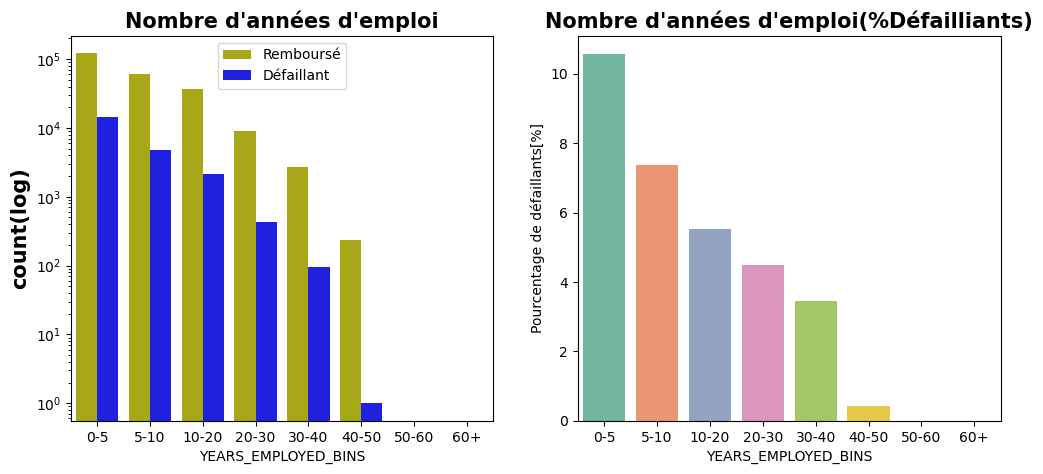

In [61]:
univar_cat (df_application_train,'YEARS_EMPLOYED_BINS',"Nombre d'années d'emploi",False,False,True)

La majorité des demandeurs ont été employés entre 0 et 5 ans. Le taux de défaillance de ce groupe est également le plus élevé, soit 10 %.

Avec l'augmentation de l'année d'emploi, le taux de défaillance diminue progressivement, les personnes ayant plus de 40 ans d'expérience ayant un taux de défaillance inférieur à 1%.

***DAYS_BIRTH : age***

In [62]:
df_application_train['AGE']=df_application_train['DAYS_BIRTH'] / -365

C:\Users\--\AppData\Local\Temp\ipykernel_8656\197329217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['AGE']=df_application_train['DAYS_BIRTH'] / -365


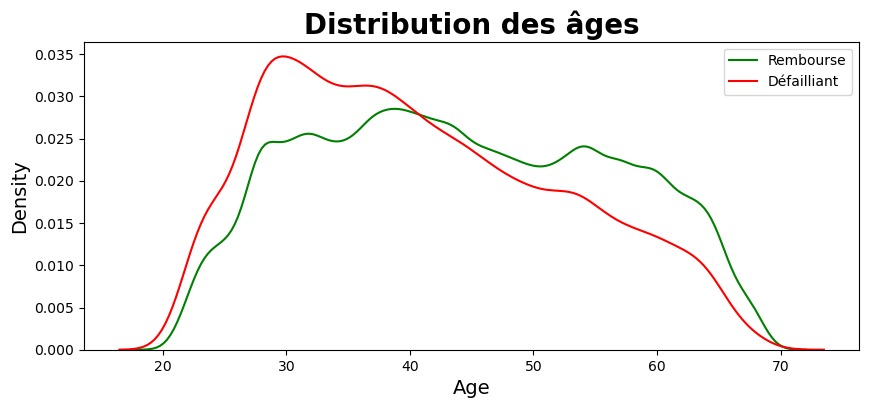

In [63]:
# convertit d’abord les jours en années pour obtenir l’âge.
plt.figure(figsize=(10,4))
sns.kdeplot(df_application_train[df_application_train['TARGET'] == 0]['AGE'],label='Rembourse',color='g')
sns.kdeplot(df_application_train[df_application_train['TARGET'] == 1]['AGE'],label='Défailliant',color='r')
plt.legend()
plt.xlabel('Age',fontsize='14')
plt.ylabel('Density',fontsize='14')
plt.title('Distribution des âges',fontsize='20',fontweight='bold')
plt.show()

In [64]:
bins = [0,10,20,30,40,50,float('inf')]
Labels = ['0-10','10-20', '20-30', '30-40', '40-50','50+']
df_application_train['AGE_BIN']= pd.cut(df_application_train['AGE'], bins=bins,labels=Labels, right=False)
df_application_train['AGE_BIN'].value_counts(normalize=True)*100

C:\Users\--\AppData\Local\Temp\ipykernel_8656\3798921573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['AGE_BIN']= pd.cut(df_application_train['AGE'], bins=bins,labels=Labels, right=False)


AGE_BIN
50+      33.712290
30-40    26.762945
40-50    24.891142
20-30    14.633623
0-10      0.000000
10-20     0.000000
Name: proportion, dtype: float64

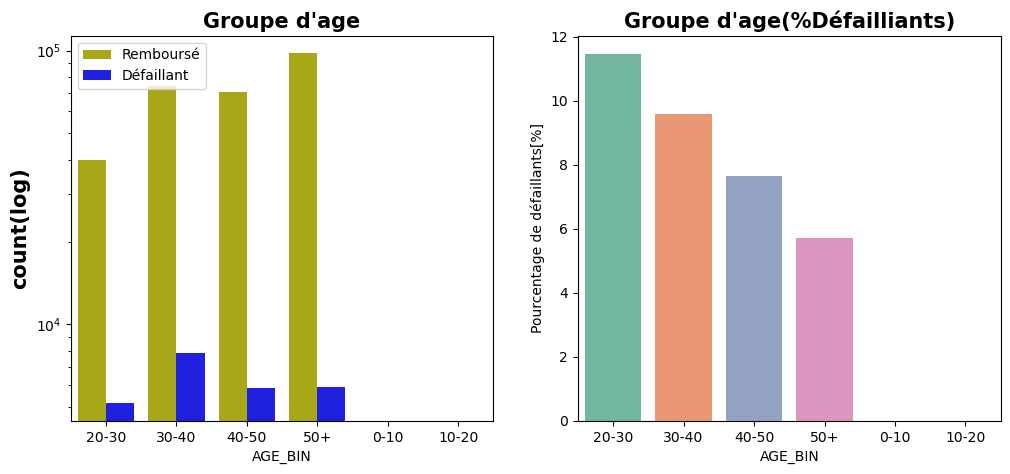

In [65]:
univar_cat (df_application_train,'AGE_BIN',"Groupe d'age")

***AMT_CREDIT :Montant du crédit du prêt***

In [66]:
def plot_distribution(df_application_train,feature,title):
    plt.figure(figsize=(10,4))
    
    t0=df_application_train.loc[df_application_train['TARGET']==0]
    t1=df_application_train.loc[df_application_train['TARGET']==1]
    sns.kdeplot(t0[feature].dropna(),label='Remboursé',color='g')
    sns.kdeplot(t1[feature].dropna(),label='Remboursé',color='r')
    plt.title(title,fontsize='20',fontweight='bold')
    plt.legend()
    plt.show()

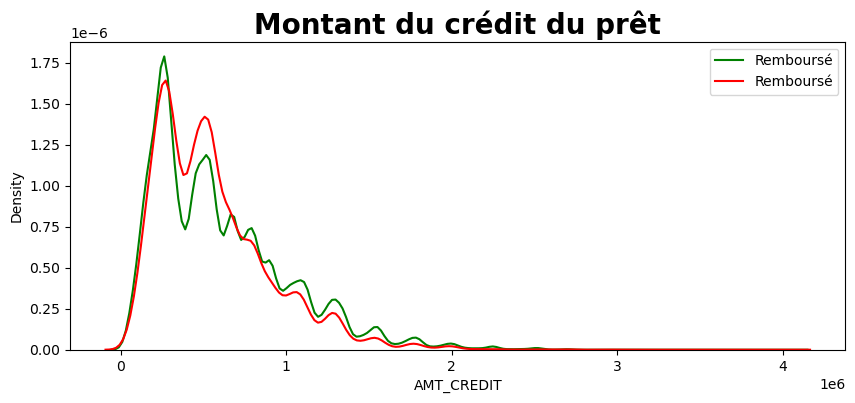

In [67]:
plot_distribution(df_application_train,'AMT_CREDIT',"Montant du crédit du prêt")

In [68]:
df_application_train['AMT_CREDIT_PRET']=df_application_train['AMT_CREDIT'] /100000
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11]
Labels = ['0-100k','100k-200k', '200k-300k', '300k-400k','400k-500k', '500k-600k','600k-700k','700k-800k','800k,900k','900k-1M','1M+']
df_application_train['AMT_CREDIT_BINS']= pd.cut(df_application_train['AMT_CREDIT_PRET'], bins=bins,labels=Labels, right=False)
df_application_train['AMT_CREDIT_BINS'].value_counts(normalize=True)*100

C:\Users\--\AppData\Local\Temp\ipykernel_8656\3468198252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['AMT_CREDIT_PRET']=df_application_train['AMT_CREDIT'] /100000
C:\Users\--\AppData\Local\Temp\ipykernel_8656\3468198252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['AMT_CREDIT_BINS']= pd.cut(df_application_train['AMT_CREDIT_PRET'], bins=bins,labels=Labels, right=False)


AMT_CREDIT_BINS
200k-300k    20.230081
500k-600k    12.634159
400k-500k    11.824409
100k-200k    11.123906
300k-400k     9.720684
600k-700k     8.875873
700k-800k     7.083647
800k,900k     5.737632
900k-1M       5.599968
1M+           4.953718
0-100k        2.215923
Name: proportion, dtype: float64

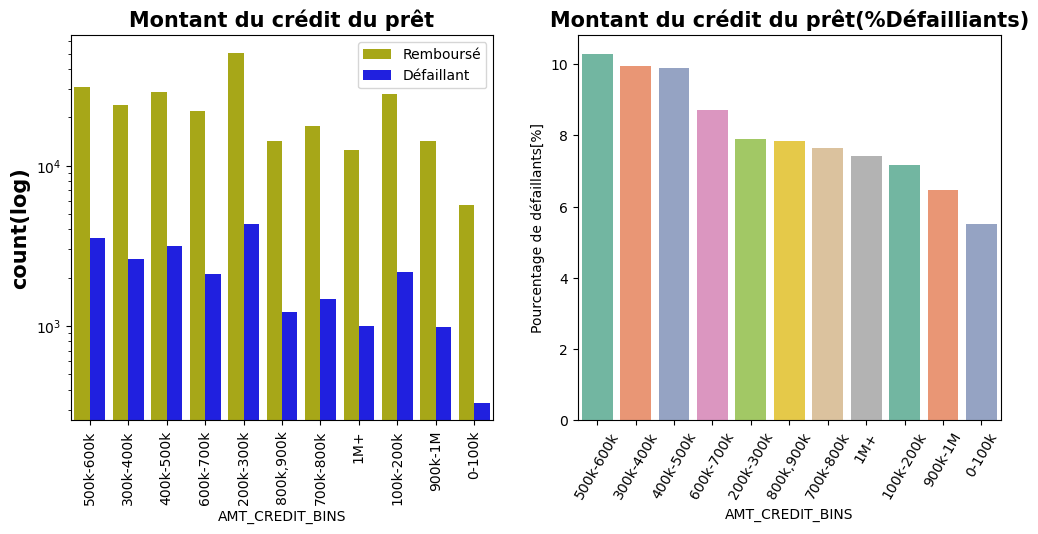

In [69]:
univar_cat (df_application_train,'AMT_CREDIT_BINS','Montant du crédit du prêt',True,True)

Plus de 80 % des prêts accordés sont d'un montant inférieur à 900 000 euros.

Les personnes qui obtiennent des prêts de 300 à 600 000 euros ont tendance à ne pas rembourser leurs emprunts plus souvent que les autres.

***AMT_INCOME_TOTAL : Revenu total***

In [70]:
df_application_train['AMT_INCOME_TOTAL_1']=df_application_train['AMT_INCOME_TOTAL'] /100000
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11]
Labels = ['0-100k','100k-200k', '200k-300k', '300k-400k','400k-500k', '500k-600k','600k-700k','700k-800k','800k,900k','900k-1M','1M+']
df_application_train['AMT_INCOME_TOTAL_BINS']= pd.cut(df_application_train['AMT_INCOME_TOTAL_1'], bins=bins,labels=Labels, right=False)
df_application_train['AMT_INCOME_TOTAL_BINS'].value_counts(normalize=True)*100

C:\Users\--\AppData\Local\Temp\ipykernel_8656\4251918623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['AMT_INCOME_TOTAL_1']=df_application_train['AMT_INCOME_TOTAL'] /100000
C:\Users\--\AppData\Local\Temp\ipykernel_8656\4251918623.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_application_train['AMT_INCOME_TOTAL_BINS']= pd.cut(df_application_train['AMT_INCOME_TOTAL_1'], bins=bins,labels=Labels, right=False)


AMT_INCOME_TOTAL_BINS
100k-200k    50.735000
200k-300k    21.210691
0-100k       20.729695
300k-400k     4.776116
400k-500k     1.744669
500k-600k     0.356354
600k-700k     0.282805
900k-1M       0.065738
700k-800k     0.052721
800k,900k     0.040354
1M+           0.005858
Name: proportion, dtype: float64

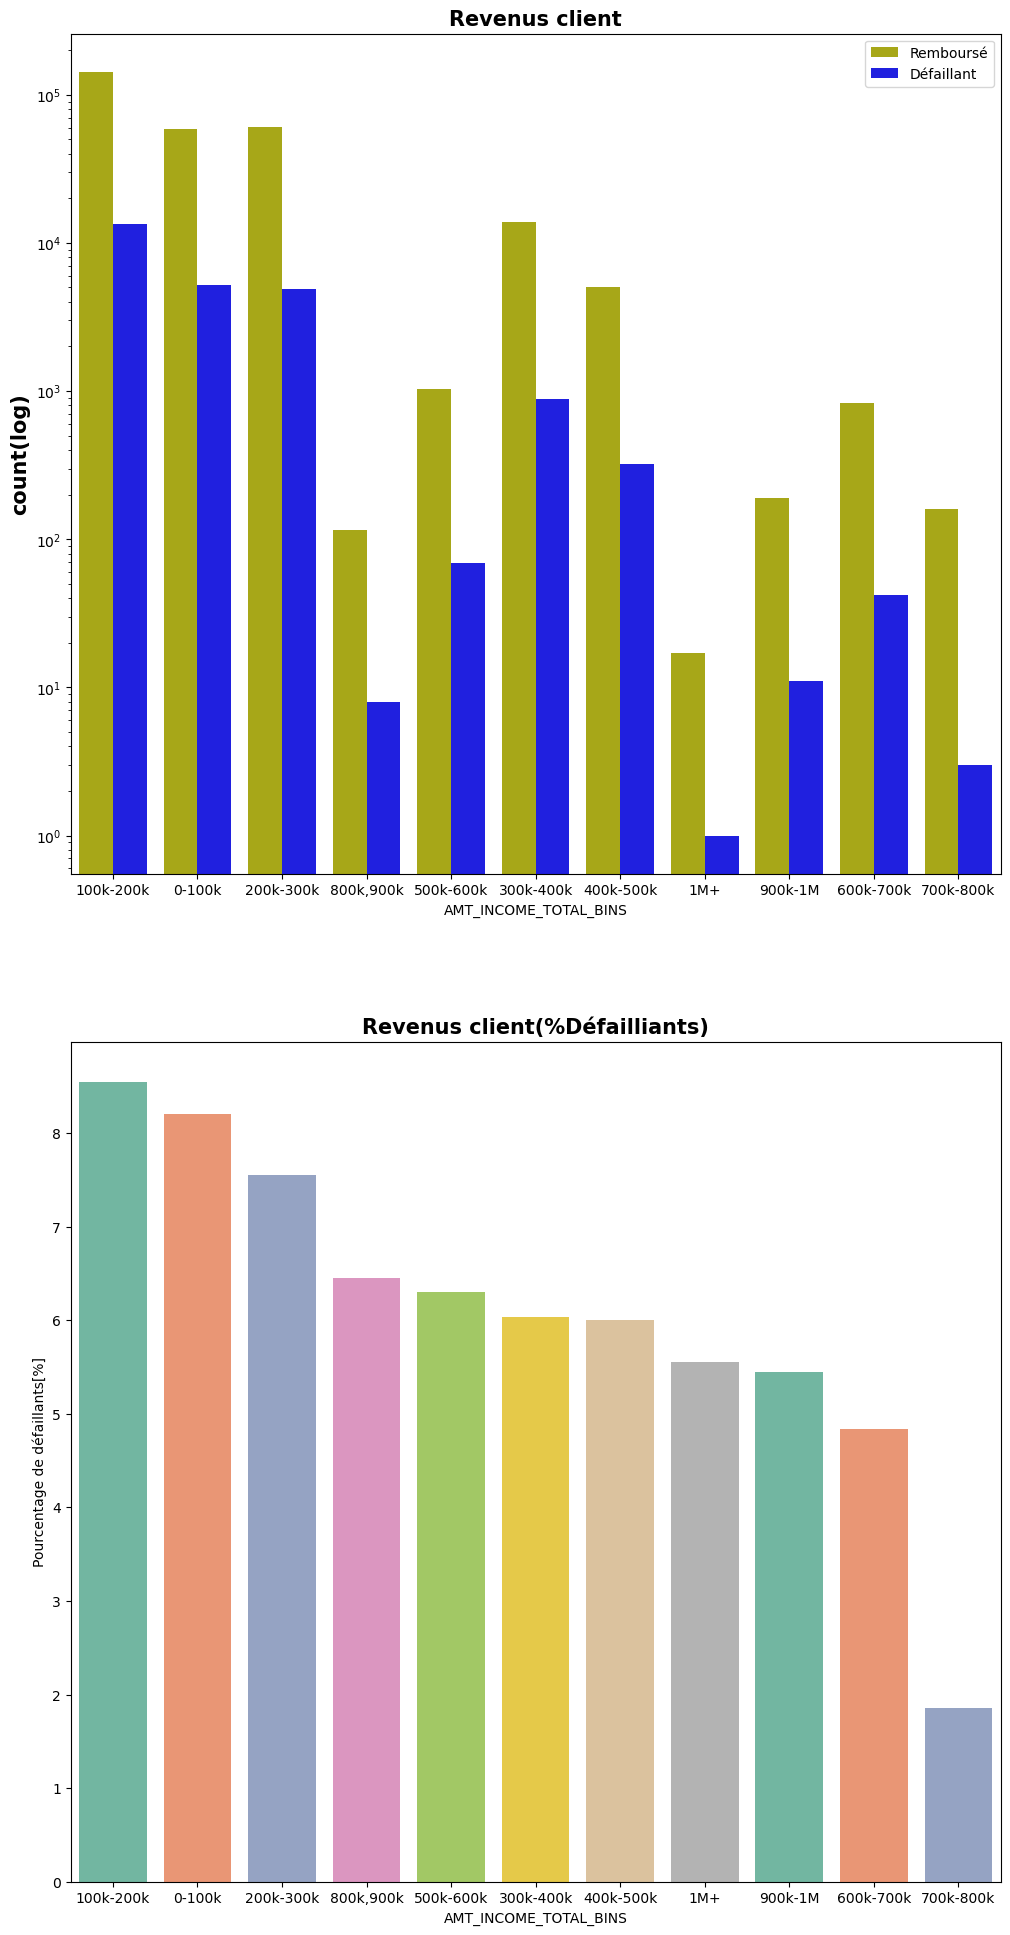

In [71]:
univar_cat (df_application_train,'AMT_INCOME_TOTAL_BINS','Revenus client',False,False,False)

90 % des demandes ont un revenu total inférieur à 300 000 euros.

Les demandes dont le revenu est inférieur à 300 000 ont une forte probabilité de défaillance.

Les demandeurs dont les revenus sont supérieurs à 700 000 ont moins de chances de se retrouver en défaut de paiement.

### Corrélation

In [72]:
num_cols=application_train.select_dtypes(include=['float64','int64'])
print('30 top correlations possitives avec TARGET:\n\n',num_cols.corr()['TARGET'].sort_values().tail(30))
print('30 top correlations négatives avec TARGET:\n\n',num_cols.corr()['TARGET'].sort_values().head(30))

30 top correlations possitives avec TARGET:

 FLAG_MOBIL                     0.000534
AMT_REQ_CREDIT_BUREAU_WEEK     0.000788
AMT_REQ_CREDIT_BUREAU_HOUR     0.000930
AMT_REQ_CREDIT_BUREAU_DAY      0.002704
LIVE_REGION_NOT_WORK_REGION    0.002819
FLAG_DOCUMENT_21               0.003709
FLAG_DOCUMENT_2                0.005417
REG_REGION_NOT_LIVE_REGION     0.005576
REG_REGION_NOT_WORK_REGION     0.006942
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.0

Les 3 variables présentant les corrélations négatives les plus fortes avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Selon la documentation, ces caractéristiques représentent un "score normalisé provenant d'une source de données externe".
Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

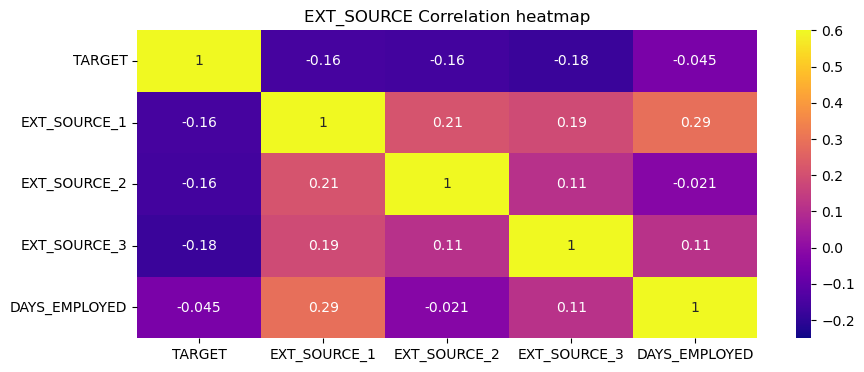

In [73]:
plt.figure(figsize=(10,4))
sns.heatmap(application_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_EMPLOYED']].corr(),cmap='plasma',vmin=-0.25,annot=True,vmax=0.6)
plt.title('EXT_SOURCE Correlation heatmap')
plt.show()

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de la EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également voir que DAYS_EMPLOYED est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'un des facteurs de ce score est peut-être le nombre de jours de travail.

Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

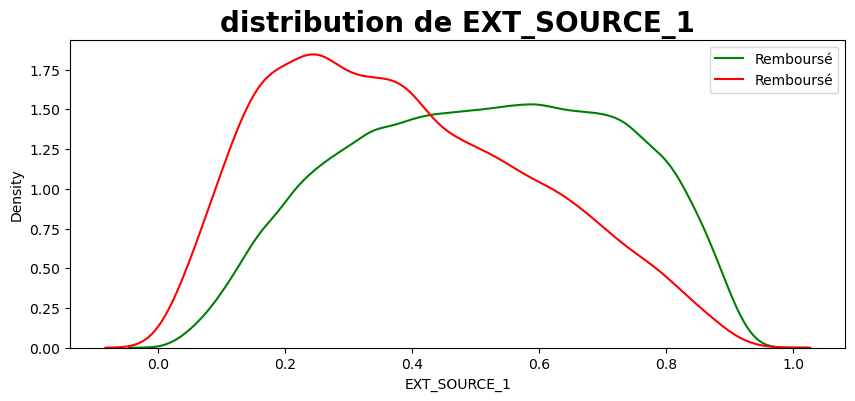

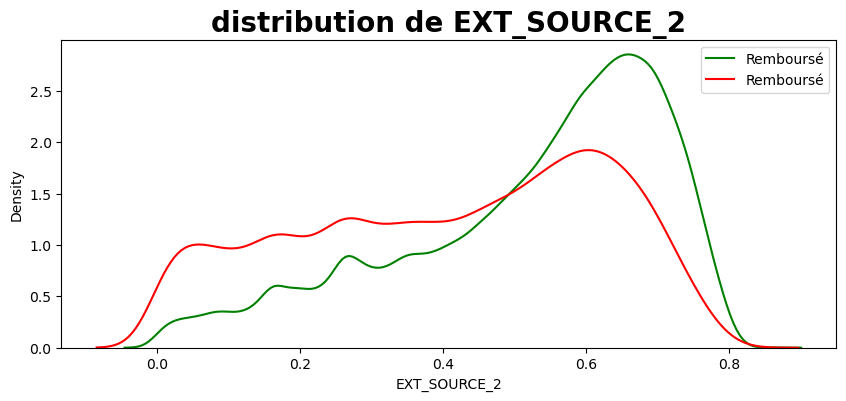

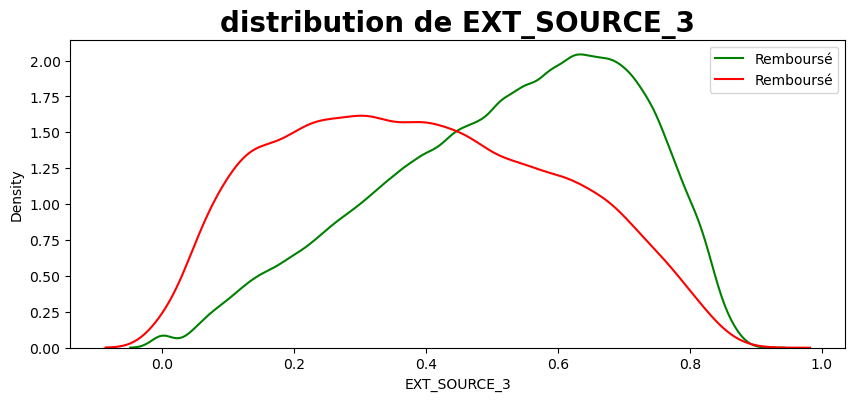

In [74]:
plot_distribution(application_train,'EXT_SOURCE_1','distribution de EXT_SOURCE_1')
plot_distribution(application_train,'EXT_SOURCE_2','distribution de EXT_SOURCE_2')
plot_distribution(application_train,'EXT_SOURCE_3','distribution de EXT_SOURCE_3')

EXT_SOURCE_3 affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte. En fait, elles sont toutes considérées comme très faibles, mais ces variables seront tout de même utiles à un modèle d'apprentissage automatique pour prédire si un demandeur remboursera ou non un prêt à temps

## FEATURES ENGINEERING

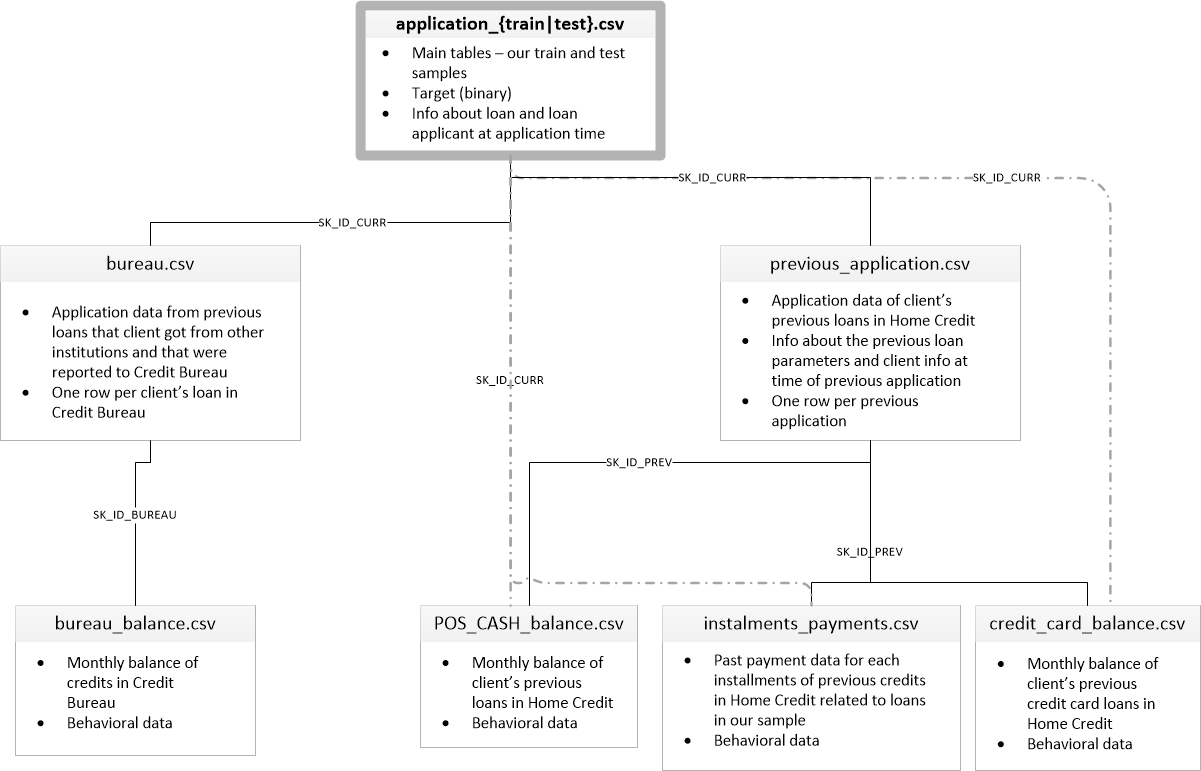

Cette partie est entierement inspirée du notebook kaggle suivant https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/

In [75]:
from contextlib import contextmanager
import numpy as np
import gc
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time()  - t0))

In [76]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [77]:
def application_train_test(PATH, num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(PATH+'/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(PATH+'/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [78]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(PATH,num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(PATH+'/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(PATH+'/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


In [79]:
# Preprocess previous_applications.csv
def previous_applications(PATH,num_rows = None, nan_as_category = True):
    prev = pd.read_csv(PATH + '/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features _APPROVED
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features join
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    approved_agg.columns =approved_agg.columns  +'_APPROVED'
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    refused_agg.columns =refused_agg.columns+'_REFUSED'
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [80]:
# Preprocess POS_CASH_balance.csv
def pos_cash(PATH,num_rows = None, nan_as_category = True):
    pos = pd.read_csv(PATH+'/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
 

In [81]:
# Preprocess installments_payments.csv
def installments_payments(PATH,num_rows = None, nan_as_category = True):
    ins = pd.read_csv(PATH+'/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [82]:
# Preprocess credit_card_balance.csv
def credit_card_balance(PATH,num_rows = None, nan_as_category = True):
    cc = pd.read_csv(PATH+'/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [83]:
import time
with timer("Process application_train and application_test"):
    df=application_train_test(PATH)
    print("Application df shape",df.shape)

Train samples: 307511, test samples: 48744
Application df shape (356251, 248)
Process application_train and application_test - done in 8s


In [84]:
with timer("Process bureau and bureau_balace"):
    bureau=bureau_and_balance(PATH)
    print('Bureau df shape:', bureau.shape)
    df=df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

Bureau df shape: (305811, 116)
Process bureau and bureau_balace - done in 25s


In [85]:
with timer("Process previous_applications"):
    prev=previous_applications(PATH)
    print('previous_application df shape:', prev.shape)
    df=df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

previous_application df shape: (338857, 249)
Process previous_applications - done in 35s


In [86]:
with timer("Process POS_CASH"):
    pos=pos_cash(PATH)
    print('pos_cash balance df shape:', pos.shape)
    df=df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()

pos_cash balance df shape: (337252, 18)
Process POS_CASH - done in 20s


In [87]:
with timer("Process installments payments"):
    ins= installments_payments(PATH)
    print('installments payments df shape:', ins.shape)
    df=df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()

installments payments df shape: (339587, 26)
Process installments payments - done in 34s


In [88]:
with timer("Process credit card balance"):
    cc= credit_card_balance(PATH)
    print('credit card balance df shape:', cc.shape)
    df=df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()

credit card balance df shape: (103558, 141)
Process credit card balance - done in 23s


In [89]:
df.to_csv('df.csv',index=False)

In [90]:
df.shape

(356251, 798)

###  Selection des 100 variables les plus Corrélées

In [91]:
df_classification_correlat = pd.get_dummies(df, drop_first=True)

# Calculer la matrice de corrélation
corr_matrix = df_classification_correlat.corr()

# Extraire la corrélation avec la colonne 'TARGET'
corr_target = corr_matrix['TARGET'].abs().sort_values(ascending=False)

# Afficher les variables les plus corrélées
top_100_correlat = corr_target.head(100)
top_100_correlat 

TARGET                                           1.000000
EXT_SOURCE_3                                     0.178926
EXT_SOURCE_2                                     0.160471
EXT_SOURCE_1                                     0.155317
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN                 0.107692
                                                   ...   
FLOORSMAX_MEDI                                   0.043773
APPROVED_HOUR_APPR_PROCESS_START_MAX_APPROVED    0.043431
ACTIVE_DAYS_CREDIT_MIN                           0.043232
FLOORSMAX_MODE                                   0.043231
OCCUPATION_TYPE_Laborers                         0.043017
Name: TARGET, Length: 100, dtype: float64

In [92]:
# Sélectionner les colonnes les plus corrélées
top_100_columns = top_100_correlat.index.tolist()
top_100_columns.append('SK_ID_CURR')
df_selected_columns = df[top_100_columns]

# Afficher le DataFrame des colonnes sélectionnées
df_selected_columns

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_RECIVABLE_MEAN,...,BURO_STATUS_0_MEAN_MEAN,FLOORSMAX_AVG,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APPROVED_AMT_ANNUITY_MAX_APPROVED,FLOORSMAX_MEDI,APPROVED_HOUR_APPR_PROCESS_START_MAX_APPROVED,ACTIVE_DAYS_CREDIT_MIN,FLOORSMAX_MODE,OCCUPATION_TYPE_Laborers,SK_ID_CURR
0,1.0,0.139376,0.262949,0.083037,NaN,NaN,-874.000000,NaN,NaN,NaN,...,0.406960,0.0833,-315.421053,9251.775,0.0833,9.0,-1042.0,0.0833,True,100002
1,0.0,NaN,0.622246,0.311267,NaN,NaN,-1400.750000,NaN,NaN,NaN,...,NaN,0.2917,-1385.320000,98356.995,0.2917,17.0,-606.0,0.2917,False,100003
2,0.0,0.729567,0.555912,NaN,NaN,NaN,-867.000000,NaN,NaN,NaN,...,NaN,NaN,-761.666667,5357.250,NaN,5.0,NaN,NaN,True,100004
3,0.0,NaN,0.650442,NaN,NaN,0.0,NaN,0.00000,0.00000,0.00000,...,NaN,NaN,-271.625000,39954.510,NaN,15.0,NaN,NaN,True,100006
4,0.0,NaN,0.322738,NaN,NaN,NaN,-1149.000000,NaN,NaN,NaN,...,NaN,NaN,-1032.242424,22678.785,NaN,15.0,NaN,NaN,False,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,NaN,0.643026,0.648575,NaN,NaN,NaN,-727.200000,NaN,NaN,NaN,...,0.513721,NaN,-630.333333,14222.430,NaN,14.0,-601.0,NaN,False,456221
356251,NaN,NaN,0.684596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-992.712329,14571.765,NaN,16.0,NaN,NaN,False,456222
356252,NaN,0.283712,0.632770,0.733503,NaN,NaN,-539.000000,NaN,NaN,NaN,...,0.378922,0.3333,-586.375000,15761.205,0.3333,20.0,-229.0,0.3333,False,456223
356253,NaN,0.595456,0.445701,0.373090,NaN,NaN,-1755.823529,NaN,NaN,NaN,...,0.235474,0.6250,-924.965517,23451.705,0.6250,15.0,-1358.0,0.6250,False,456224


In [93]:
df_selected_columns.columns


Index(['TARGET', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MAX',
       'BURO_DAYS_CREDIT_MEAN', 'CC_AMT_BALANCE_MEAN',
       'CC_AMT_TOTAL_RECEIVABLE_MEAN', 'CC_AMT_RECIVABLE_MEAN',
       ...
       'BURO_STATUS_0_MEAN_MEAN', 'FLOORSMAX_AVG',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'APPROVED_AMT_ANNUITY_MAX_APPROVED',
       'FLOORSMAX_MEDI', 'APPROVED_HOUR_APPR_PROCESS_START_MAX_APPROVED',
       'ACTIVE_DAYS_CREDIT_MIN', 'FLOORSMAX_MODE', 'OCCUPATION_TYPE_Laborers',
       'SK_ID_CURR'],
      dtype='object', length=101)

In [94]:
df_classification=df_selected_columns[df_selected_columns['TARGET'].notnull()]
df_test = df_selected_columns[df_selected_columns['TARGET'].isnull()]
print("taille des données d'entrainement:{}".format(len(df_classification)))
print("taille des données de test:{}".format(len(df_test)))

taille des données d'entrainement:307507
taille des données de test:48744


## Traitement des valeurs manquantes

Nous mettons en place un seuil au-delà duquel c'est une colonne présente plus 50% de valeurs manquantes, nous préférons la supprimer

In [95]:
messing_value=(pd.DataFrame(df_classification.isna().sum(),columns=['messing_value']).sort_values(by='messing_value',ascending=False).apply(lambda x:round(x/df_classification.shape[0]*100,2)))
messing_value

,messing_value
CC_CNT_DRAWINGS_POS_CURRENT_VAR,80.26
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,80.26
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,80.12
CC_CNT_DRAWINGS_POS_CURRENT_MAX,80.12
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,80.12
...,...
NAME_INCOME_TYPE_Working,0.00
REGION_RATING_CLIENT,0.00
REGION_RATING_CLIENT_W_CITY,0.00
DAYS_BIRTH,0.00


In [96]:
# Sélectionner uniquement les colonnes avec moins de 50% de valeurs manquantes
columns_less_than_50_missing = messing_value[messing_value['messing_value'] < 50].index

# Créer un nouveau DataFrame avec uniquement ces colonnes du DataFrame original
df_classification_imputed = df_classification[columns_less_than_50_missing]

# Afficher le DataFrame avec les colonnes sélectionnées
df_classification_imputed

,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,EXT_SOURCE_3,...,NAME_EDUCATION_TYPE_Secondary / secondary special,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,CODE_GENDER,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH,SK_ID_CURR
0,0.0833,0.0833,0.0833,780.0,-572.5,-103.0,-1042.0,-1437.0,-974.500000,0.139376,...,True,0,-2120,0,False,True,2,2,-9461,100002
1,0.2917,0.2917,0.2917,1216.0,-606.0,-606.0,-606.0,-2586.0,-1665.666667,NaN,...,False,0,-291,1,True,False,1,1,-16765,100003
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1326.0,-867.000000,0.729567,...,True,0,-2531,0,False,True,2,2,-19046,100004
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,0,-2437,1,False,True,2,2,-19005,100006
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1149.0,-1149.000000,NaN,...,True,1,-3458,0,False,True,2,2,-19932,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.6042,0.6042,0.4583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,0,-1982,0,False,True,1,1,-9327,456251
307507,0.0833,0.0833,0.0833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,0,-4090,1,False,False,2,2,-20775,456252
307508,0.1667,0.1667,0.1667,1113.0,-816.0,-713.0,-919.0,-919.0,-919.000000,0.218859,...,False,1,-5150,1,True,True,3,3,-14966,456253
307509,0.0417,0.0417,0.0417,NaN,NaN,NaN,NaN,-1104.0,-1104.000000,0.661024,...,True,1,-931,1,False,False,2,2,-11961,456254


- On garde que les columns deja choisis sur df_train pour df_test

In [177]:
data_test=df_test[df_classification_imputed.columns]
data_test.shape

(48744, 52)

In [180]:
# Limiter data_test à 200 lignes avec iloc
data_test = data_test.iloc[:200]

In [181]:
data_test.shape

(200, 52)

In [179]:
# Limiter le DataFrame à 500 lignes avec iloc
data_sample_limited = data_sample.iloc[:500]

# Exporter le DataFrame limité en CSV
data_sample=data_sample_limited.to_csv('data_sample.csv', index=False)

In [98]:
pd.set_option('display.max_columns',None)

In [99]:
data_test.head(2)

,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,EXT_SOURCE_3,DAYS_EMPLOYED_PERC,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,APPROVED_AMT_ANNUITY_MEAN_APPROVED,APPROVED_AMT_ANNUITY_MAX_APPROVED,APPROVED_HOUR_APPR_PROCESS_START_MAX_APPROVED,APPROVED_DAYS_DECISION_MIN_APPROVED,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_DAYS_DECISION_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_DAYS_DECISION_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Laborers,TARGET,FLAG_EMP_PHONE,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Pensioner,NAME_EDUCATION_TYPE_Secondary / secondary special,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,CODE_GENDER,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH,SK_ID_CURR
307511,0.125,0.125,0.125,1778.0,-309.333333,-49.0,-559.0,-1572.0,-1054.25,0.159520,0.121044,-2329.0,82.428571,-735.000000,0.0,0.571429,-49.0,0.428571,-1572.0,-93.142857,3951.0,3951.0,13.0,-1740.0,1.0,-1740.0,0.0,0.0,1.0,0.0,0.0,-1740.0,-2195.000000,0.789654,-1740.0,1,0,False,NaN,1,False,False,False,0,-812,1,True,True,2,2,-19241,100001
307512,NaN,NaN,NaN,1324.0,-99.500000,-62.0,-137.0,-373.0,-373.00,0.432962,0.247398,-4469.0,439.333333,-190.666667,0.0,0.333333,-62.0,0.666667,-373.0,-54.333333,4813.2,4813.2,11.0,-757.0,0.5,-536.0,0.0,0.0,1.0,0.0,0.0,-757.0,-609.555556,0.291656,0.0,1,0,False,NaN,1,False,False,True,0,-1623,0,False,True,2,2,-18064,100005


In [100]:
df_classification.head(2)

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,CC_AMT_RECIVABLE_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_DAYS_CREDIT_MIN,DAYS_EMPLOYED,PREV_CODE_REJECT_REASON_XAP_MEAN,CC_AMT_INST_MIN_REGULARITY_MEAN,BURO_MONTHS_BALANCE_MIN_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MAX,BURO_DAYS_CREDIT_UPDATE_MEAN,CC_AMT_BALANCE_MAX,CC_AMT_TOTAL_RECEIVABLE_MAX,CC_AMT_RECIVABLE_MAX,DAYS_EMPLOYED_PERC,CC_AMT_RECEIVABLE_PRINCIPAL_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,REFUSED_DAYS_DECISION_MAX_REFUSED,CC_AMT_BALANCE_MIN,ACTIVE_DAYS_CREDIT_MEAN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_RECIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MIN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,CC_AMT_RECEIVABLE_PRINCIPAL_MIN,CC_CNT_DRAWINGS_CURRENT_VAR,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_MIN,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_DAYS_CREDIT_MIN,BURO_STATUS_1_MEAN_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_VAR,REGION_RATING_CLIENT_W_CITY,REFUSED_DAYS_DECISION_MEAN_REFUSED,CC_COUNT,ACTIVE_DAYS_CREDIT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_NAME_CONTRACT_STATUS_Active_SUM,CC_MONTHS_BALANCE_SUM,REGION_RATING_CLIENT,CC_MONTHS_BALANCE_VAR,CC_AMT_DRAWINGS_CURRENT_MEAN,CLOSED_DAYS_CREDIT_MEAN,CLOSED_MONTHS_BALANCE_SIZE_MEAN,NAME_INCOME_TYPE_Working,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,NAME_EDUCATION_TYPE_Higher education,BURO_STATUS_C_MEAN_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,PREV_CODE_REJECT_REASON_HC_MEAN,APPROVED_DAYS_DECISION_MIN_APPROVED,PREV_DAYS_DECISION_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_MAX,REFUSED_HOUR_APPR_PROCESS_START_MIN_REFUSED,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,CC_CNT_DRAWINGS_CURRENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_SUM,NAME_EDUCATION_TYPE_Secondary / secondary special,BURO_DAYS_CREDIT_MAX,REFUSED_DAYS_DECISION_MIN_REFUSED,CC_CNT_DRAWINGS_POS_CURRENT_VAR,BURO_DAYS_CREDIT_ENDDATE_MEAN,PREV_DAYS_DECISION_MEAN,NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_XNA,FLAG_EMP_PHONE,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_INST_MIN_REGULARITY_VAR,APPROVED_AMT_ANNUITY_MEAN_APPROVED,BURO_CREDIT_TYPE_Microloan_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,BURO_STATUS_0_MEAN_MEAN,FLOORSMAX_AVG,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,APPROVED_AMT_ANNUITY_MAX_APPROVED,FLOORSMAX_MEDI,APPROVED_HOUR_APPR_PROCESS_START_MAX_APPROVED,ACTIVE_DAYS_CREDIT_MIN,FLOORSMAX_MODE,OCCUPATION_TYPE_Laborers,SK_ID_CURR
0,1.0,0.139376,0.262949,0.083037,NaN,NaN,-874.00,NaN,NaN,NaN,NaN,NaN,13.75,0.75,-9461,0.0,0.25,-1437.0,-637.0,1.0,NaN,-47.0,NaN,-499.875,NaN,NaN,NaN,0.067329,NaN,10.0,NaN,NaN,-572.5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-47.0,-1437.0,0.255682,NaN,2,NaN,NaN,-103.0,NaN,NaN,NaN,2,NaN,NaN,-974.500000,15.0,True,0.0,False,0.175426,0.0,-1134.0,0,0.0,-606.0,-606.0,NaN,NaN,NaN,-2120,0,NaN,NaN,True,-103.0,NaN,NaN,-349.0,-606.0,False,False,1,NaN,NaN,9251.775,0.0,780.0,0,1,0.40696,0.0833,-315.421053,9251.775,0.0833,9.0,-1042.0,0.0833,True,100002
1,0.0,NaN,0.622246,0.311267,NaN,NaN,-1400.75,NaN,NaN,NaN,NaN,NaN,NaN,0.75,-16765,0.0,0.25,-2586.0,-1188.0,1.0,NaN,NaN,NaN,-816.000,NaN,NaN,NaN,0.070862,NaN,NaN,NaN,NaN,-606.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-2586.0,NaN,NaN,1,NaN,NaN,-606.0,NaN,NaN,NaN,1,NaN,NaN,-1665.666667,NaN,False,0.0,True,NaN,0.0,-828.0,1,0.0,-2341.0,-2341.0,NaN,NaN,NaN,-291,0,NaN,NaN,False,-606.0,NaN,NaN,-544.5,-1305.0,False,False,1,NaN,NaN,56553.990,0.0,1216.0,0,1,NaN,0.2917,-1385.320000,98356.995,0.2917,17.0,-606.0,0.2917,False,100003


In [ ]:
# Remplacer les valeurs manquantes par la moyenne de chaque colonne
df_classification_imputed = df_classification_imputed.fillna(df_classification_imputed.mean())

In [182]:
# Remplacer les valeurs manquantes par la moyenne de chaque colonne
data_test = data_test.fillna(data_test.mean())
# Remplir les valeurs manquantes restantes par une valeur fixe (par exemple, 0)
data_test = data_test.fillna(0)
# Afficher le DataFrame avec les valeurs manquantes imputées
data_test

,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MEAN,EXT_SOURCE_3,DAYS_EMPLOYED_PERC,DAYS_EMPLOYED,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_DAYS_CREDIT_MAX,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,APPROVED_AMT_ANNUITY_MEAN_APPROVED,APPROVED_AMT_ANNUITY_MAX_APPROVED,APPROVED_HOUR_APPR_PROCESS_START_MAX_APPROVED,APPROVED_DAYS_DECISION_MIN_APPROVED,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_DAYS_DECISION_MEAN,PREV_NAME_PRODUCT_TYPE_walk-in_MEAN,PREV_CODE_REJECT_REASON_SCOFR_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,PREV_DAYS_DECISION_MIN,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Laborers,TARGET,FLAG_EMP_PHONE,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Pensioner,NAME_EDUCATION_TYPE_Secondary / secondary special,REG_CITY_NOT_WORK_CITY,DAYS_ID_PUBLISH,CODE_GENDER,NAME_EDUCATION_TYPE_Higher education,NAME_INCOME_TYPE_Working,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DAYS_BIRTH,SK_ID_CURR
307511,0.125000,0.125000,0.125000,1778.000000,-309.333333,-49.000000,-559.000000,-1572.00000,-1054.250000,0.159520,0.121044,-2329.000000,82.428571,-735.000000,0.00000,0.571429,-49.000000,0.428571,-1572.000000,-93.142857,3951.00000,3951.000,13.0,-1740.0,1.000000,-1740.000000,0.0,0.0,1.00,0.00,0.0,-1740.0,-2195.000000,0.789654,-1740.0,1,0,False,0.0,1,False,False,False,0,-812,1,True,True,2,2,-19241,100001
307512,0.224124,0.223967,0.220653,1324.000000,-99.500000,-62.000000,-137.000000,-373.00000,-373.000000,0.432962,0.247398,-4469.000000,439.333333,-190.666667,0.00000,0.333333,-62.000000,0.666667,-373.000000,-54.333333,4813.20000,4813.200,11.0,-757.0,0.500000,-536.000000,0.0,0.0,1.00,0.00,0.0,-757.0,-609.555556,0.291656,0.0,1,0,False,0.0,1,False,False,True,0,-1623,0,False,True,2,2,-18064,100005
307513,0.224124,0.223967,0.220653,5911.574324,-652.266864,-423.870968,-943.625806,-2070.00000,-1737.500000,0.610991,0.222477,-4458.000000,-1068.000000,-1737.500000,0.00000,1.000000,-1210.000000,0.000000,-2070.000000,-775.500000,11478.19500,23153.985,18.0,-1999.0,0.750000,-837.500000,0.0,0.0,1.00,0.00,0.0,-1999.0,-1358.109677,0.699787,-856.0,0,0,False,0.0,1,False,False,False,0,-3503,0,True,True,2,2,-20038,100013
307514,0.375000,0.375000,0.375000,30885.000000,-1050.400000,-269.000000,-1821.000000,-2105.00000,-1652.714286,0.612704,0.133515,-1866.000000,2387.700000,-1401.750000,0.00000,0.583333,-269.000000,0.416667,-2105.000000,-651.500000,8091.58500,11250.000,13.0,-1805.0,0.600000,-1124.200000,0.0,0.0,0.80,0.00,0.0,-1805.0,-858.548673,0.509677,-1805.0,1,0,False,0.0,1,False,False,True,0,-4208,1,False,True,2,2,-13976,100028
307515,0.224124,0.223967,0.220653,5911.574324,-652.266864,-423.870968,-943.625806,-1862.51634,-1361.560857,0.478137,0.168021,-2191.000000,1062.082583,-1073.269692,0.00822,0.574706,-501.106742,0.421388,-1732.174157,-534.240405,11100.60000,11100.600,4.0,-821.0,0.500000,-466.000000,0.0,0.0,1.00,0.00,0.0,-821.0,-634.250000,0.425687,-821.0,1,0,False,0.0,1,False,False,True,1,-4262,0,False,True,2,2,-13040,100038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307706,0.224124,0.223967,0.220653,5911.574324,-652.266864,-423.870968,-943.625806,-1862.51634,-1361.560857,0.478137,0.056210,-778.000000,1062.082583,-1073.269692,0.00822,0.574706,-501.106742,0.421388,-1732.174157,-534.240405,6906.60000,6906.600,13.0,-879.0,0.500000,-879.000000,0.0,0.0,0.50,0.50,0.5,-879.0,-844.000000,0.730846,-879.0,1,0,False,0.0,1,False,False,False,0,-4767,1,True,False,2,2,-13841,101345
307707,0.224124,0.223967,0.220653

In [102]:
def missing_general(df):
    total_cells=np.product(df.shape)
    missing_cells= df.isnull().sum().sum()
    missing_percent=(missing_cells/total_cells)*100
    print('Nombre total de cellules manquantes:', missing_cells)
    print('Nombre de cellules manquantes en %,{:2f}%'.format(missing_percent))
missing_general(df_classification_imputed)

Nombre total de cellules manquantes: 0
Nombre de cellules manquantes en %,0.000000%


In [103]:
missing_general(data_test)

Nombre total de cellules manquantes: 0
Nombre de cellules manquantes en %,0.000000%


In [183]:
# Export des données avant modélisation
data_test.to_csv('data_test.csv', index=False)

In [105]:
df_classification_imputed.to_csv('data_after_feat_eng.csv', index=False)

Extraction d'un échantillon de 10 prêt qui servira à tester l'API en production

In [171]:
data_sample=df_classification_imputed.iloc[:500]
# Export de l'échantillon
data_sample.to_csv('data_sample.csv', index=False)

# Partie 2 : Modelisation 

In [107]:
import mlflow
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, recall_score, precision_score, auc, fbeta_score, make_scorer
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV, learning_curve
import gc 
import time
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pickle
import lightgbm as lgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [108]:
# Séparer les caractéristiques (X) et la cible (y)
X = df_classification_imputed.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_classification_imputed['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Normaliser les données
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:
# Sauvegarde du modèle de scaler entrainé
with open("scaler.pkl", "wb") as fichier:
    pickle.dump(scaler, fichier)

In [110]:
import subprocess
# Commande pour démarrer le serveur MLflow en local sur l'hôte 127.0.0.1 et le port 5000
cmd = ['mlflow','server','--host','127.0.0.1','--port', '2024']
# Exécuter la commande pour démarrer le serveur MLflow
process = subprocess.Popen(cmd)
# Configurer l'URI de suivi de MLflow pour pointer vers le serveur local
mlflow.set_tracking_uri('http://127.0.0.1:2024')
experiments = mlflow.search_experiments()
experiment_ids=[exp.experiment_id for exp in experiments]
experiment_ids

['232265814667554854',
 '409375672717215134',
 '247999834826571996',
 '462104897038772728',
 '170558985684331243',
 '772601438244668964',
 '129862013267812483',
 '268793203435055510',
 '0']

## Fonctions utiles

In [111]:
# Fonction pour tracer la courbe ROC et calculer l'AUC
def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [112]:
# Fonction pour tracer la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

## DummyClassiffer

In [113]:
# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:2024")

# Initialiser le DummyClassifier avec la stratégie 'stratified'
dummy_clf = DummyClassifier(strategy='stratified')

# Définir l'expérience MLflow
mlflow.set_experiment("DummyClassifiers_Model")
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='dummy_clf_with_stratified_strategy'):
    # Enregistrement des hyperparamètres avant l'entraînement
    mlflow.log_param("model_type", "DummyClassifier")
    mlflow.log_param("strategy", "stratified")

    # Entraîner le modèle DummyClassifier
    dummy_clf.fit(X_train, y_train)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_dummy = dummy_clf.predict(X_train)
    y_train_prob_dummy = dummy_clf.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_dummy = dummy_clf.predict(X_test)
    y_test_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]

    # Calcul du score AUC ROC sur le jeu d'entraînement
    auc_roc_score_train = roc_auc_score(y_train, y_train_prob_dummy)

    # Calcul du score AUC ROC sur le jeu de test
    auc_roc_score_test = roc_auc_score(y_test, y_test_prob_dummy)   

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu d'entraînement
    recall_train = recall_score(y_train, y_train_pred_dummy)
    precision_train = precision_score(y_train, y_train_pred_dummy)
    accuracy_train = accuracy_score(y_train, y_train_pred_dummy)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_dummy)
    precision_test = precision_score(y_test, y_test_pred_dummy)
    accuracy_test = accuracy_score(y_test, y_test_pred_dummy)

    # Enregistrement des métriques dans MLflow print
    mlflow.log_metric("auc_roc_score_train", auc_roc_score_train)
    mlflow.log_metric("auc_roc_score_test", auc_roc_score_test)
    mlflow.log_metric("recall_train", recall_train)
    mlflow.log_metric("precision_train", precision_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Enregistrement du modèle DummyClassifier dans MLflow
    model_uri = "dummy_clf_model_with_stratified_strategy"
    mlflow.sklearn.log_model(dummy_clf, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "DummyClassifier_with_Stratified_Strategy"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)
    
end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'AUC ROC Score': [auc_roc_score_train, auc_roc_score_test],
    'Recall': [recall_train, recall_test],
    'Precision': [precision_train, precision_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

results_df_auc_dummy = pd.DataFrame(results)

# Afficher le tableau des résultats
results_df_auc_dummy

2024/10/16 19:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DummyClassifier_with_Stratified_Strategy' already exists. Creating a new version of this model...
2024/10/16 19:35:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier_with_Stratified_Strategy, version 6
Created version '6' of model 'DummyClassifier_with_Stratified_Strategy'.
2024/10/16 19:35:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run dummy_clf_with_stratified_strategy at: http://127.0.0.1:2024/#/experiments/268793203435055510/runs/6b80e82b541342a4b89c3ae445d8daa3.
2024/10/16 19:35:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/268793203435055510.


Temps d'exécution : 18.08 secondes


,Dataset,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.498709,0.081571,0.082406,0.852529
1,Test,0.500649,0.079758,0.078431,0.850052


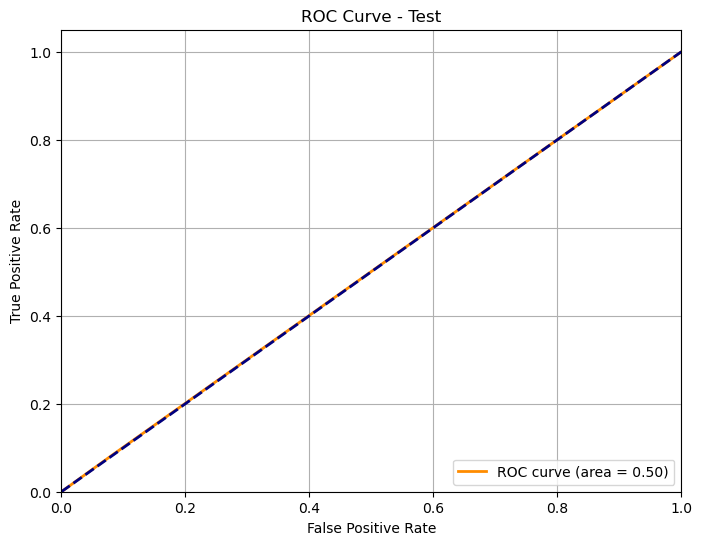

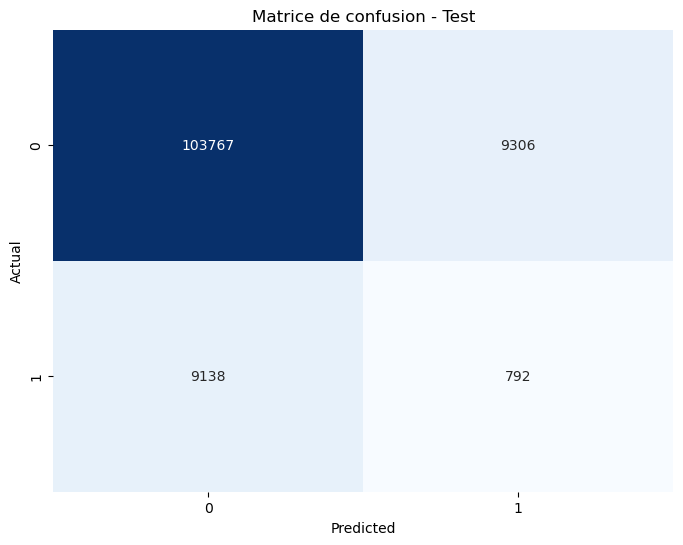

In [114]:
# Tracer les courbes ROC
plot_roc_curve(y_test, y_test_prob_dummy, 'ROC Curve - Test')

# Tracer les matrices de confusion
plot_confusion_matrix(y_test, y_test_pred_dummy, 'Matrice de confusion - Test')

### Coût métier DummyClassifier

In [115]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le DummyClassifier avec la stratégie 'stratified'
dummy_clf = DummyClassifier(strategy='stratified')

# Définir l'expérience MLflow
mlflow.set_experiment("DummyClassifiers_Model_with_Fbeta")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='dummy_clf_with_stratified_strategy_and_Fbeta'):
    # Enregistrement des hyperparamètres avant l'entraînement
    mlflow.log_param("model_type", "DummyClassifier")
    mlflow.log_param("strategy", "stratified")

    # Entraîner le modèle DummyClassifier
    dummy_clf.fit(X_train, y_train)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_dummy = dummy_clf.predict(X_train)
    y_train_prob_dummy = dummy_clf.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_dummy = dummy_clf.predict(X_test)
    y_test_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]

    # Calcul du score AUC ROC sur le jeu d'entraînement
    auc_roc_score_train = roc_auc_score(y_train, y_train_prob_dummy)

    # Calcul du score AUC ROC sur le jeu de test
    auc_roc_score_test = roc_auc_score(y_test, y_test_prob_dummy)

    # Calcul du score F-beta sur le jeu d'entraînement
    fbeta_train = fbeta_score(y_train, y_train_pred_dummy, beta=10)

    # Calcul du score F-beta sur le jeu de test
    fbeta_test = fbeta_score(y_test, y_test_pred_dummy, beta=10)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("auc_roc_score_train", auc_roc_score_train)
    mlflow.log_metric("auc_roc_score_test", auc_roc_score_test)
    mlflow.log_metric("fbeta_train", fbeta_train)
    mlflow.log_metric("fbeta_test", fbeta_test)

    # Enregistrement du modèle DummyClassifier dans MLflow
    model_uri = "dummy_clf_model_with_stratified_strategy_and_fbeta"
    mlflow.sklearn.log_model(dummy_clf, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "DummyClassifier_with_Stratified_Strategy_Fbeta"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'AUC ROC Score': [auc_roc_score_train, auc_roc_score_test],
    'F-beta Score': [fbeta_train, fbeta_test]
}

results_df_score_dummy = pd.DataFrame(results)

# Afficher le tableau des résultats
results_df_score_dummy

2024/10/16 19:35:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run selective-mole-440 at: http://127.0.0.1:2024/#/experiments/268793203435055510/runs/44da8434084f41a3824ba72a66f13061.
2024/10/16 19:35:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/268793203435055510.
2024/10/16 19:35:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'DummyClassifier_with_Stratified_Strategy_Fbeta' already exists. Creating a new version of this model...
2024/10/16 19:35:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier_with_Stratified_Strategy_Fbeta, version 6
Created version '6' of model 'DummyClassifier_with_Stratified_Strategy_Fbeta'.
2024/10/16 19:35:53 INFO mlflow.tracking._tracking_service.c

Temps d'exécution : 6.53 secondes


,Dataset,AUC ROC Score,F-beta Score
0,Entraînement,0.500867,0.080771
1,Test,0.499994,0.080376


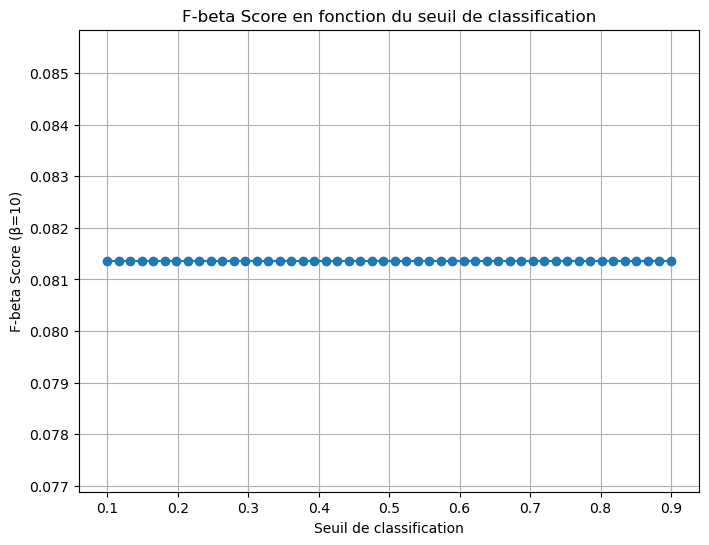

In [116]:
# Calcul du F-beta Score pour différents seuils
thresholds = np.linspace(0.1, 0.9, 50)
fbeta_scores = []

for threshold in thresholds:
    y_pred = (y_test_prob_dummy >= threshold).astype(int)
    fbeta = fbeta_score(y_test, y_pred, beta=10)
    fbeta_scores.append(fbeta)

# Trouver l'indice du maximum de F-beta Score
max_index = np.argmax(fbeta_scores)
max_threshold = thresholds[max_index]
max_score = fbeta_scores[max_index]

# Tracé du F-beta Score en fonction du seuil
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fbeta_scores, marker='o')
plt.xlabel('Seuil de classification')
plt.ylabel('F-beta Score (β=10)')
plt.title('F-beta Score en fonction du seuil de classification')
plt.grid(True)
plt.show()

## Modèle non-linéaire - LGBM

In [117]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # Importer le pipeline de imblearn

# Initialiser le modèle LightGBM
lgbm = lgb.LGBMClassifier()

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'lgbm__num_leaves': [31, 50],
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__n_estimators': [100, 200]
}

# Créer un pipeline avec SMOTE, StandardScaler et LightGBM
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # Sur-échantillonnage des classes minoritaires
    ('scaler', StandardScaler()),       # Normalisation des données
    ('lgbm', lgbm)                      # Modèle LightGBM
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le scoreur AUC ROC
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1)

# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Définir l'expérience MLflow
mlflow.set_experiment("LightGBM_Models_with_SMOTE_and_Normalization")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='lgbm_with_SMOTE_GridSearchCV_and_AUC_ROC'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "LightGBM")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_lgbm = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_lgbm}")

    # Meilleur modèle entraîné
    best_lgbm_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_lgbm)

    # Prédictions sur le jeu de test
    y_test_pred_lgbm = best_lgbm_model.predict(X_test)
    y_test_prob_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

    # Calcul du score AUC ROC sur le jeu de test
    auc_roc_score_test = roc_auc_score(y_test, y_test_prob_lgbm)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_lgbm)
    precision_test = precision_score(y_test, y_test_pred_lgbm)
    accuracy_test = accuracy_score(y_test, y_test_pred_lgbm)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("auc_roc_score_test", auc_roc_score_test)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "lgbm_model_with_SMOTE_and_auc_roc"
    mlflow.sklearn.log_model(best_lgbm_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "LightGBM_with_SMOTE_and_Normalization_Model"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")
# Créer un DataFrame avec les résultats des métriques
results = {
    'Dataset': ['Entraînement', 'Test'],
    'AUC ROC Score': [auc_roc_score_test, auc_roc_score_test],
    'Recall': [recall_test, recall_test],
    'Precision': [precision_test, precision_test],
    'Accuracy': [accuracy_test, accuracy_test]
}

# Convertir les résultats en DataFrame
results_df_auc_lgbm = pd.DataFrame(results)

# Afficher le tableau des résultats
results_df_auc_lgbm

2024/10/16 19:35:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-shad-892 at: http://127.0.0.1:2024/#/experiments/129862013267812483/runs/9e20e950ddc947c79fe67c51f67d4363.
2024/10/16 19:35:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/129862013267812483.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 169609, number of negative: 169609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9457
[LightGBM] [Info] Number of data points in the train set: 339218, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs hyperparamètres trouvés : {'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 200, 'lgbm__num_leaves': 31}


2024/10/16 19:42:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LightGBM_with_SMOTE_and_Normalization_Model' already exists. Creating a new version of this model...
2024/10/16 19:42:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_with_SMOTE_and_Normalization_Model, version 6
Created version '6' of model 'LightGBM_with_SMOTE_and_Normalization_Model'.
2024/10/16 19:42:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run lgbm_with_SMOTE_GridSearchCV_and_AUC_ROC at: http://127.0.0.1:2024/#/experiments/772601438244668964/runs/b82d67a7975542358640b536394604fc.
2024/10/16 19:42:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/772601438244668964.


Temps d'exécution : 422.05 secondes


,Dataset,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.731286,0.048439,0.34931,0.915896
1,Test,0.731286,0.048439,0.34931,0.915896


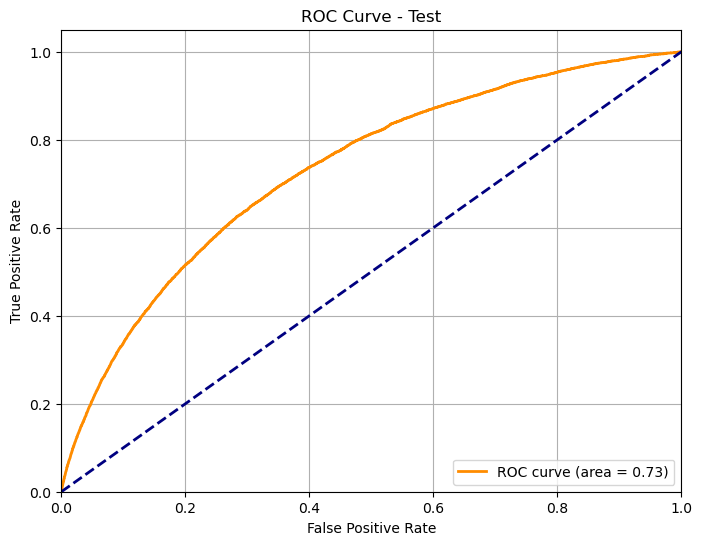

In [118]:
# Tracer les courbes ROC
plot_roc_curve(y_test, y_test_prob_lgbm, 'ROC Curve - Test')


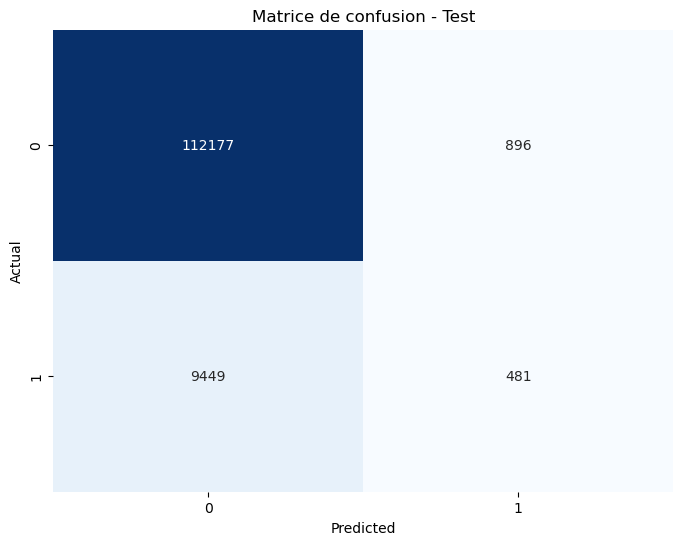

In [119]:
# Tracer les matrices de confusion
plot_confusion_matrix(y_test, y_test_pred_lgbm, 'Matrice de confusion - Test')

### Cout metier fbeta lgbm

In [120]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le modèle LightGBM
lgbm = lgb.LGBMClassifier()

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'lgbm__num_leaves': [31, 50],
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__n_estimators': [100, 200]
}

# Créer un pipeline avec SMOTE, normalisation et LightGBM
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),         # Sur-échantillonnage des classes minoritaires
    ('scaler', preprocessing.StandardScaler()), # Normalisation des données
    ('lgbm', lgbm)                              # Modèle LightGBM
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le scoreur F-beta (beta=10)
fbeta_scorer = make_scorer(fbeta_score, beta=10)

# Utiliser GridSearchCV avec F-beta score
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=fbeta_scorer, cv=skf, n_jobs=-1, verbose=1)

# Définir l'expérience MLflow
mlflow.set_experiment("LightGBM_Model_with_Fbeta")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='lgbm_with_GridSearchCV_and_Fbeta'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "LightGBM")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_lgbm = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_lgbm}")

    # Meilleur modèle entraîné
    best_lgbm_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_lgbm)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_lgbm = best_lgbm_model.predict(X_train)
    y_train_prob_lgbm = best_lgbm_model.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_lgbm = best_lgbm_model.predict(X_test)
    y_test_prob_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

    # Calcul du score F-beta sur le jeu d'entraînement
    fbeta_train = fbeta_score(y_train, y_train_pred_lgbm, beta=10)

    # Calcul du score F-beta sur le jeu de test
    fbeta_test = fbeta_score(y_test, y_test_pred_lgbm, beta=10)

    # Calcul du score AUC ROC sur le jeu d'entraînement
    auc_roc_score_train = roc_auc_score(y_train, y_train_prob_lgbm)

    # Calcul du score AUC ROC sur le jeu de test
    auc_roc_score_test = roc_auc_score(y_test, y_test_prob_lgbm)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu d'entraînement
    recall_train = recall_score(y_train, y_train_pred_lgbm)
    precision_train = precision_score(y_train, y_train_pred_lgbm)
    accuracy_train = accuracy_score(y_train, y_train_pred_lgbm)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_lgbm)
    precision_test = precision_score(y_test, y_test_pred_lgbm)
    accuracy_test = accuracy_score(y_test, y_test_pred_lgbm)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("fbeta_train", fbeta_train)
    mlflow.log_metric("fbeta_test", fbeta_test)
    mlflow.log_metric("auc_roc_score_train", auc_roc_score_train)
    mlflow.log_metric("auc_roc_score_test", auc_roc_score_test)
    mlflow.log_metric("recall_train", recall_train)
    mlflow.log_metric("precision_train", precision_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "lgbm_model_with_SMOTE_and_fbeta"
    mlflow.sklearn.log_model(best_lgbm_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "LightGBM_with_SMOTE_Model_Fbeta"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'F-beta Score': [fbeta_train, fbeta_test],
    'AUC ROC Score': [auc_roc_score_train, auc_roc_score_test],
    'Recall': [recall_train, recall_test],
    'Precision': [precision_train, precision_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

# Convertir les résultats en DataFrame et les afficher
results_df_score_lgbm = pd.DataFrame(results)
results_df_score_lgbm

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 169609, number of negative: 169609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9457
[LightGBM] [Info] Number of data points in the train set: 339218, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Meilleurs hyperparamètres trouvés : {'lgbm__learning_rate': 0.01, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}


2024/10/16 19:48:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LightGBM_with_SMOTE_Model_Fbeta' already exists. Creating a new version of this model...
2024/10/16 19:48:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_with_SMOTE_Model_Fbeta, version 6
Created version '6' of model 'LightGBM_with_SMOTE_Model_Fbeta'.
2024/10/16 19:48:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run lgbm_with_GridSearchCV_and_Fbeta at: http://127.0.0.1:2024/#/experiments/170558985684331243/runs/de520336632a4659ac5fc2def00a202a.
2024/10/16 19:48:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/170558985684331243.


Temps d'exécution : 358.29 secondes


,Dataset,F-beta Score,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.273811,0.680677,0.275394,0.173836,0.835841
1,Test,0.274002,0.680960,0.275629,0.172279,0.834614


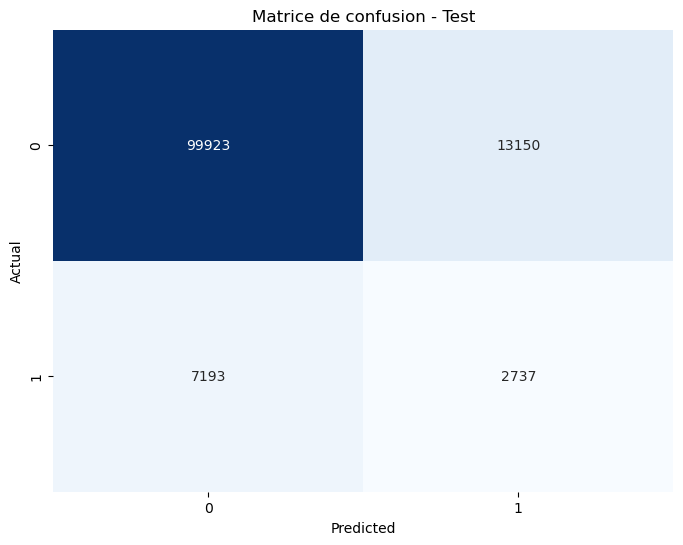

In [121]:
plot_confusion_matrix(y_test, y_test_pred_lgbm, 'Matrice de confusion - Test')

In [122]:
# Générer les probabilités de prédiction pour le jeu de test
y_test_prob_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

# Définir une gamme de seuils
thresholds = np.arange(0.0, 1.1, 0.01)

# Initialiser une liste pour stocker les scores F-beta
fbeta_scores = []

# Calculer le score F-beta pour chaque seuil
for threshold in thresholds:
    y_test_pred_threshold = (y_test_prob_lgbm >= threshold).astype(int)
    fbeta = fbeta_score(y_test, y_test_pred_threshold, beta=10)
    fbeta_scores.append(fbeta)

# Trouver le meilleur score F-beta et le seuil correspondant
best_fbeta_score = max(fbeta_scores)
best_threshold = thresholds[fbeta_scores.index(best_fbeta_score)]

# Afficher le meilleur score F-beta et le seuil correspondant
print(f"Meilleur score F-beta (β=10): {best_fbeta_score:.4f} avec le seuil: {best_threshold:.2f}")

Meilleur score F-beta (β=10): 0.8987 avec le seuil: 0.00


## Modèle linéaire - Régression logistique


In [123]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le modèle de régression logistique
log_reg = LogisticRegression(solver='liblinear')

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2']
}

# Créer un pipeline avec SMOTE, StandardScaler et la régression logistique
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),               # Sur-échantillonnage des classes minoritaires
    ('scaler', preprocessing.StandardScaler()),      # Normalisation des données
    ('log_reg', log_reg)                             # Régression logistique
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le scoreur AUC ROC
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1)

# Définir l'expérience MLflow
mlflow.set_experiment("Logistic_Regression_with_SMOTE_and_Normalization")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='log_reg_with_SMOTE_and_Normalization'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "LogisticRegression")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_rl = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_rl}")

    # Meilleur modèle entraîné
    best_log_reg_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_rl)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_log_reg = best_log_reg_model.predict(X_train)
    y_train_prob_log_reg = best_log_reg_model.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_log_reg = best_log_reg_model.predict(X_test)
    y_test_prob_log_reg = best_log_reg_model.predict_proba(X_test)[:, 1]

    # Calcul du score AUC ROC sur le jeu d'entraînement
    auc_roc_score_train = roc_auc_score(y_train, y_train_prob_log_reg)

    # Calcul du score AUC ROC sur le jeu de test
    auc_roc_score_test = roc_auc_score(y_test, y_test_prob_log_reg)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu d'entraînement
    recall_train = recall_score(y_train, y_train_pred_log_reg)
    precision_train = precision_score(y_train, y_train_pred_log_reg)
    accuracy_train = accuracy_score(y_train, y_train_pred_log_reg)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_log_reg)
    precision_test = precision_score(y_test, y_test_pred_log_reg)
    accuracy_test = accuracy_score(y_test, y_test_pred_log_reg)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("auc_roc_score_train", auc_roc_score_train)
    mlflow.log_metric("auc_roc_score_test", auc_roc_score_test)
    mlflow.log_metric("recall_train", recall_train)
    mlflow.log_metric("precision_train", precision_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "log_reg_model_with_SMOTE_and_Normalization"
    mlflow.sklearn.log_model(best_log_reg_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "LogisticRegression_with_SMOTE_and_Normalization_Model"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'AUC ROC Score': [auc_roc_score_train, auc_roc_score_test],
    'Recall': [recall_train, recall_test],
    'Precision': [precision_train, precision_test],
    'Accuracy': [accuracy_train, accuracy_test]
}
results_df_lr = pd.DataFrame(results)
results_df_lr

2024/10/16 19:49:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-deer-545 at: http://127.0.0.1:2024/#/experiments/170558985684331243/runs/969a15bdda2447d2b9d6c1af7ed2823d.
2024/10/16 19:49:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/170558985684331243.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs hyperparamètres trouvés : {'log_reg__C': 0.01, 'log_reg__penalty': 'l2'}


2024/10/16 20:04:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_with_SMOTE_and_Normalization_Model' already exists. Creating a new version of this model...
2024/10/16 20:04:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_with_SMOTE_and_Normalization_Model, version 5
Created version '5' of model 'LogisticRegression_with_SMOTE_and_Normalization_Model'.
2024/10/16 20:04:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run log_reg_with_SMOTE_and_Normalization at: http://127.0.0.1:2024/#/experiments/462104897038772728/runs/894d39019f7c48ada88eed1bc6b38c7b.
2024/10/16 20:04:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/462104897038772728.


Temps d'exécution : 945.94 secondes


,Dataset,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.660650,0.406714,0.161006,0.781007
1,Test,0.669708,0.420443,0.165333,0.781859


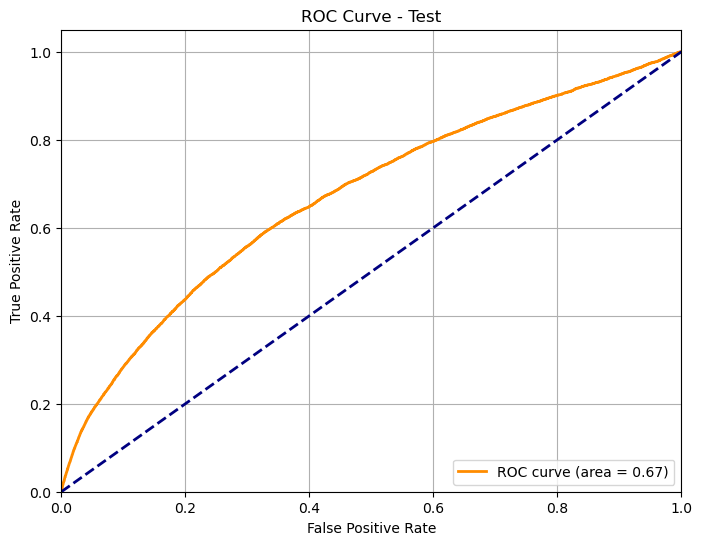

In [124]:
# Tracer les courbes ROC
plot_roc_curve(y_test, y_test_prob_log_reg, 'ROC Curve - Test')

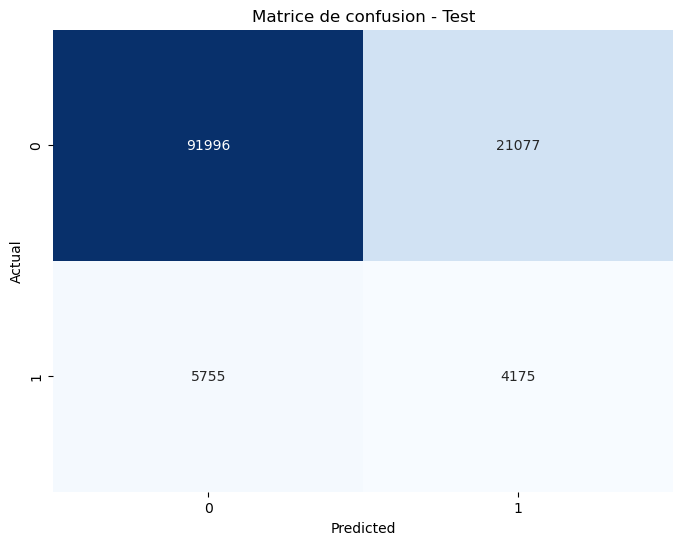

In [125]:
# Tracer les matrices de confusion
plot_confusion_matrix(y_test, y_test_pred_log_reg, 'Matrice de confusion - Test')

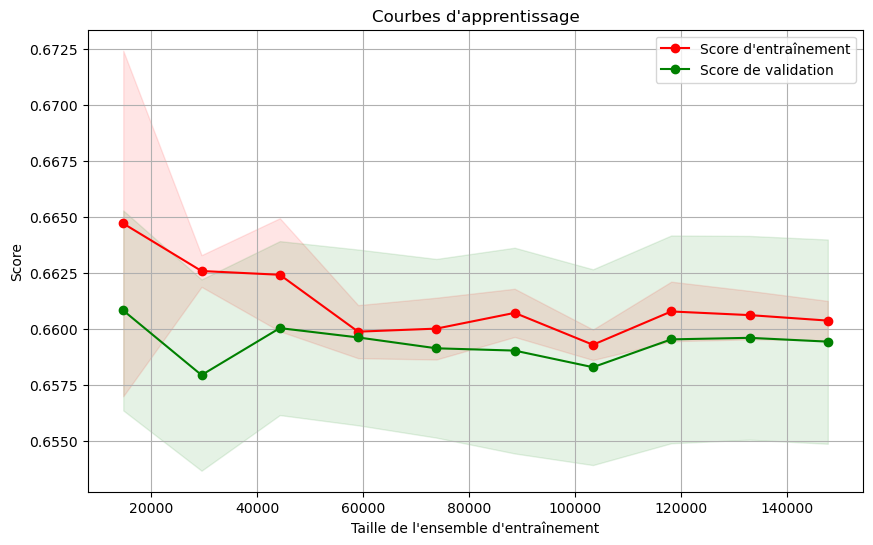

In [126]:
# Fonction pour tracer les courbes d'apprentissage
def plot_learning_curves(estimator, X, y, cv, scoring):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

    plt.xlabel("Taille de l'ensemble d'entraînement")
    plt.ylabel("Score")
    plt.title("Courbes d'apprentissage")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Tracer les courbes d'apprentissage pour le modèle de régression logistique
plot_learning_curves(best_log_reg_model, X_train, y_train, cv=skf, scoring='roc_auc')

### Cout metier_GridSearchCV_and_Fbeta_LogisticRegression

In [148]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le modèle de régression logistique
log_reg = LogisticRegression(solver='liblinear')

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2']
}

# Créer un pipeline avec SMOTE et la régression logistique
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)), ('scaler', preprocessing.StandardScaler()),
    ('log_reg', log_reg)
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le score F-beta (beta=10)
fbeta_scorer = make_scorer(fbeta_score, beta=10)

# Utiliser GridSearchCV avec F-beta score
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=fbeta_scorer, cv=skf, n_jobs=-1, verbose=1)

# Définir l'expérience MLflow
mlflow.set_experiment("LogisticRegression_with_SMOTE_Model_No_Validation")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='log_reg_with_GridSearchCV_and_Fbeta_no_validation'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "LogisticRegression")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_rl = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_rl}")

    # Meilleur modèle entraîné
    best_log_reg_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_rl)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_log_reg = best_log_reg_model.predict(X_train)
    y_train_pred_prob_log_reg = best_log_reg_model.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_log_reg = best_log_reg_model.predict(X_test)
    y_test_pred_prob_log_reg = best_log_reg_model.predict_proba(X_test)[:, 1]

    # Calcul du score F-beta sur le jeu d'entraînement
    fbeta_train = fbeta_score(y_train, y_train_pred_log_reg, beta=10)
    print(f"Score F-beta sur le jeu d'entraînement : {fbeta_train}")

    # Calcul du score F-beta sur le jeu de test
    fbeta_test = fbeta_score(y_test, y_test_pred_log_reg, beta=10)
    print(f"Score F-beta sur le jeu de test : {fbeta_test}")

    # Enregistrement des métriques F-beta dans MLflow
    mlflow.log_metric("fbeta_train", fbeta_train)
    mlflow.log_metric("fbeta_test", fbeta_test)

    # Calcul de l'accuracy sur le jeu d'entraînement et de test
    accuracy_train = accuracy_score(y_train, y_train_pred_log_reg)
    accuracy_test = accuracy_score(y_test, y_test_pred_log_reg)

    # Afficher les résultats d'accuracy
    print(f"Accuracy sur le jeu d'entraînement : {accuracy_train:.4f}")
    print(f"Accuracy sur le jeu de test : {accuracy_test:.4f}")

    # Enregistrement des accuracy dans MLflow
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Calcul de l'AUC sur le jeu d'entraînement et test
    auc_train = roc_auc_score(y_train, y_train_pred_prob_log_reg)
    auc_test = roc_auc_score(y_test, y_test_pred_prob_log_reg)

    # Afficher les résultats d'AUC
    print(f"AUC sur le jeu d'entraînement : {auc_train:.4f}")
    print(f"AUC sur le jeu de test : {auc_test:.4f}")

    # Enregistrement des AUC dans MLflow
    mlflow.log_metric("auc_train", auc_train)
    mlflow.log_metric("auc_test", auc_test)

    # Calcul du rappel et de la précision sur le jeu d'entraînement
    recall_train = recall_score(y_train, y_train_pred_log_reg)
    precision_train = precision_score(y_train, y_train_pred_log_reg)

    # Calcul du rappel et de la précision sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_log_reg)
    precision_test = precision_score(y_test, y_test_pred_log_reg)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("recall_train", recall_train)
    mlflow.log_metric("precision_train", precision_train)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "log_reg_model_with_SMOTE_and_fbeta_no_validation"
    mlflow.sklearn.log_model(best_log_reg_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "LogisticRegression_with_SMOTE_Model_Fbeta_No_Validation"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'F-beta Score': [fbeta_train, fbeta_test],
    'AUC ROC Score': [auc_train, auc_test],
    'Recall': [recall_train, recall_test],
    'Precision': [precision_train, precision_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

results_df_score_log_reg_no_val = pd.DataFrame(results)
results_df_score_log_reg_no_val

2024/10/16 21:07:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-toad-12 at: http://127.0.0.1:2024/#/experiments/232265814667554854/runs/df4eb90ea96f418aa02e666b34c591bf.
2024/10/16 21:07:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/232265814667554854.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs hyperparamètres trouvés : {'log_reg__C': 10, 'log_reg__penalty': 'l2'}
Score F-beta sur le jeu d'entraînement : 0.39961939887024595
Score F-beta sur le jeu de test : 0.4127501848856361
Accuracy sur le jeu d'entraînement : 0.7812
Accuracy sur le jeu de test : 0.7821
AUC sur le jeu d'entraînement : 0.6604
AUC sur le jeu de test : 0.6695


2024/10/16 21:25:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LogisticRegression_with_SMOTE_Model_Fbeta_No_Validation' already exists. Creating a new version of this model...
2024/10/16 21:25:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_with_SMOTE_Model_Fbeta_No_Validation, version 6
Created version '6' of model 'LogisticRegression_with_SMOTE_Model_Fbeta_No_Validation'.
2024/10/16 21:25:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run log_reg_with_GridSearchCV_and_Fbeta_no_validation at: http://127.0.0.1:2024/#/experiments/247999834826571996/runs/1ee22eac867c4bed9ad512644e3571a1.
2024/10/16 21:25:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/247999834826571996.


Temps d'exécution : 1058.67 secondes


,Dataset,F-beta Score,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.399619,0.660448,0.405639,0.160871,0.781203
1,Test,0.412750,0.669454,0.419033,0.165139,0.782078


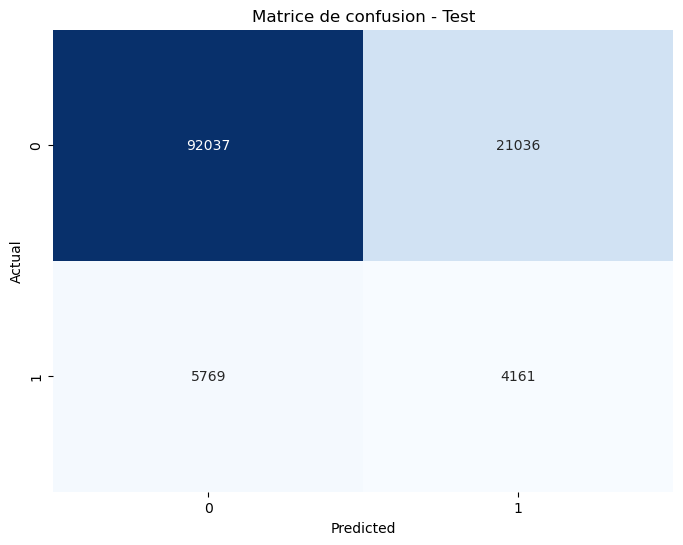

In [149]:
# Tracer les matrices de confusion
plot_confusion_matrix(y_test, y_test_pred_log_reg, 'Matrice de confusion - Test')

Optimiser le seuil de décision afin de réduire le nombre d’erreurs coûteuses (FN) tout en conservant un contrôle sur les métriques techniques comme l’AUC et l’accuracy

In [150]:
# Définir une gamme de seuils
thresholds = np.arange(0.0, 1.0, 0.01)

# Initialiser une liste pour stocker les scores F-beta
fbeta_scores = []

# Calculer le score F-beta pour chaque seuil
for threshold in thresholds:
    y_test_pred_threshold = (y_test_prob_log_reg >= threshold).astype(int)
    fbeta = fbeta_score(y_test, y_test_pred_threshold, beta=10)
    fbeta_scores.append(fbeta)

# Trouver le meilleur score F-beta et le seuil correspondant
best_fbeta_score = max(fbeta_scores)
best_threshold = thresholds[fbeta_scores.index(best_fbeta_score)]

# Afficher le meilleur score F-beta et le seuil correspondant
print(f"Meilleur score F-beta (β=10): {best_fbeta_score:.4f} avec le seuil: {best_threshold:.2f}")

Meilleur score F-beta (β=10): 0.8987 avec le seuil: 0.00


## Modèle xgboost

In [151]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le modèle XGBClassifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'xgb_clf__n_estimators': [50, 100, 200],
    'xgb_clf__max_depth': [3, 5, 7],
    'xgb_clf__learning_rate': [0.01, 0.1, 0.2]
}

# Créer un pipeline avec SMOTE, StandardScaler et XGBClassifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),               # Sur-échantillonnage des classes minoritaires
    ('scaler', preprocessing.StandardScaler()),      # Normalisation des données
    ('xgb_clf', xgb_clf)                             # XGBClassifier
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le scoreur AUC ROC
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=skf, n_jobs=-1, verbose=1)

# Définir l'expérience MLflow
mlflow.set_experiment("XGBClassifier_with_SMOTE_and_Normalization")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='xgb_clf_with_SMOTE_and_Normalization'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "XGBClassifier")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_xgb = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_xgb}")

    # Meilleur modèle entraîné
    best_xgb_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_xgb)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_xgb = best_xgb_model.predict(X_train)
    y_train_prob_xgb = best_xgb_model.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_xgb = best_xgb_model.predict(X_test)
    y_test_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calcul du score AUC ROC sur le jeu d'entraînement
    auc_roc_score_train = roc_auc_score(y_train, y_train_prob_xgb)

    # Calcul du score AUC ROC sur le jeu de test
    auc_roc_score_test = roc_auc_score(y_test, y_test_prob_xgb)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu d'entraînement
    recall_train = recall_score(y_train, y_train_pred_xgb)
    precision_train = precision_score(y_train, y_train_pred_xgb)
    accuracy_train = accuracy_score(y_train, y_train_pred_xgb)

    # Calcul du rappel, de la précision et de l'exactitude sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_xgb)
    precision_test = precision_score(y_test, y_test_pred_xgb)
    accuracy_test = accuracy_score(y_test, y_test_pred_xgb)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("auc_roc_score_train", auc_roc_score_train)
    mlflow.log_metric("auc_roc_score_test", auc_roc_score_test)
    mlflow.log_metric("recall_train", recall_train)
    mlflow.log_metric("precision_train", precision_train)
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "xgb_clf_model_with_SMOTE_and_Normalization"
    mlflow.sklearn.log_model(best_xgb_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "XGBClassifier_with_SMOTE_and_Normalization_Model"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'AUC ROC Score': [auc_roc_score_train, auc_roc_score_test],
    'Recall': [recall_train, recall_test],
    'Precision': [precision_train, precision_test],
    'Accuracy': [accuracy_train, accuracy_test]
}
results_df_xgb = pd.DataFrame(results)
results_df_xgb

2024/10/17 00:28:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-duck-659 at: http://127.0.0.1:2024/#/experiments/247999834826571996/runs/9d5e562462af44fca160bf146c5a1e27.
2024/10/17 00:28:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/247999834826571996.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\anacond\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres trouvés : {'xgb_clf__learning_rate': 0.1, 'xgb_clf__max_depth': 7, 'xgb_clf__n_estimators': 200}


2024/10/17 00:43:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBClassifier_with_SMOTE_and_Normalization_Model' already exists. Creating a new version of this model...
2024/10/17 00:43:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier_with_SMOTE_and_Normalization_Model, version 6
Created version '6' of model 'XGBClassifier_with_SMOTE_and_Normalization_Model'.
2024/10/17 00:43:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_clf_with_SMOTE_and_Normalization at: http://127.0.0.1:2024/#/experiments/409375672717215134/runs/f313488582874581b4a3074956ba03ca.
2024/10/17 00:43:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/409375672717215134.


Temps d'exécution : 877.72 secondes


,Dataset,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.824111,0.114199,0.588378,0.922040
1,Test,0.723753,0.062135,0.324055,0.913823


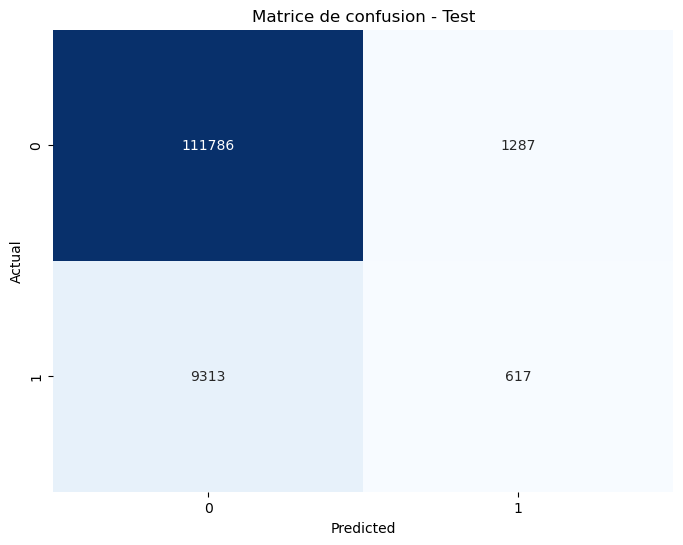

In [152]:
plot_confusion_matrix(y_test, y_test_pred_xgb, 'Matrice de confusion - Test')

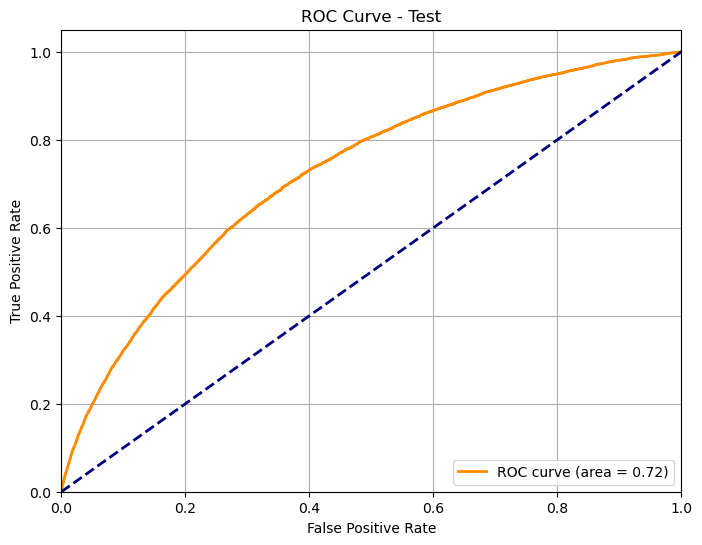

In [153]:
plot_roc_curve(y_test, y_test_prob_xgb, 'ROC Curve - Test')

### xgboost fbeta_score

In [154]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 6, 9]
}

# Créer un pipeline avec SMOTE et XGBoost
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)), ('scaler', preprocessing.StandardScaler()),
    ('xgb', xgb_model)
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le score F-beta (beta=10)
fbeta_scorer = make_scorer(fbeta_score, beta=10)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=fbeta_scorer, cv=skf, n_jobs=-1, verbose=1)

# Définir l'expérience MLflow
mlflow.set_experiment("XGBoost_with_SMOTE_Model_No_Validation")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='xgb_with_GridSearchCV_and_Fbeta_no_validation'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "XGBoost")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_xgb = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_xgb}")

    # Meilleur modèle entraîné
    best_xgb_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_xgb)

    # Prédictions sur le jeu d'entraînement
    y_train_pred_xgb = best_xgb_model.predict(X_train)
    y_train_prob_xgb = best_xgb_model.predict_proba(X_train)[:, 1]

    # Prédictions sur le jeu de test
    y_test_pred_xgb = best_xgb_model.predict(X_test)
    y_test_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

    # Calcul du score F-beta sur le jeu d'entraînement
    fbeta_train = fbeta_score(y_train, y_train_pred_xgb, beta=10)
    print(f"Score F-beta sur le jeu d'entraînement : {fbeta_train}")

    # Calcul du score F-beta sur le jeu de test
    fbeta_test = fbeta_score(y_test, y_test_pred_xgb, beta=10)
    print(f"Score F-beta sur le jeu de test : {fbeta_test}")

    # Enregistrement des métriques F-beta dans MLflow
    mlflow.log_metric("fbeta_train", fbeta_train)
    mlflow.log_metric("fbeta_test", fbeta_test)

    # Calcul de l'accuracy sur le jeu d'entraînement et de test
    accuracy_train = accuracy_score(y_train, y_train_pred_xgb)
    accuracy_test = accuracy_score(y_test, y_test_pred_xgb)

    # Afficher les résultats d'accuracy
    print(f"Accuracy sur le jeu d'entraînement : {accuracy_train:.4f}")
    print(f"Accuracy sur le jeu de test : {accuracy_test:.4f}")

    # Enregistrement des accuracy dans MLflow
    mlflow.log_metric("accuracy_train", accuracy_train)
    mlflow.log_metric("accuracy_test", accuracy_test)

    # Calcul de l'AUC sur le jeu d'entraînement et test
    auc_train = roc_auc_score(y_train, y_train_prob_xgb)
    auc_test = roc_auc_score(y_test, y_test_prob_xgb)

    # Afficher les résultats d'AUC
    print(f"AUC sur le jeu d'entraînement : {auc_train:.4f}")
    print(f"AUC sur le jeu de test : {auc_test:.4f}")

    # Enregistrement des AUC dans MLflow
    mlflow.log_metric("auc_train", auc_train)
    mlflow.log_metric("auc_test", auc_test)

    # Calcul du rappel et de la précision sur le jeu d'entraînement
    recall_train = recall_score(y_train, y_train_pred_xgb)
    precision_train = precision_score(y_train, y_train_pred_xgb)

    # Calcul du rappel et de la précision sur le jeu de test
    recall_test = recall_score(y_test, y_test_pred_xgb)
    precision_test = precision_score(y_test, y_test_pred_xgb)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("recall_train", recall_train)
    mlflow.log_metric("precision_train", precision_train)
    mlflow.log_metric("recall_test", recall_test)
    mlflow.log_metric("precision_test", precision_test)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "xgb_model_with_SMOTE_and_fbeta_no_validation"
    mlflow.sklearn.log_model(best_xgb_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "XGBoost_with_SMOTE_Model_Fbeta_No_Validation"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats
results = {
    'Dataset': ['Entraînement', 'Test'],
    'F-beta Score': [fbeta_train, fbeta_test],
    'AUC ROC Score': [auc_train, auc_test],
    'Recall': [recall_train, recall_test],
    'Precision': [precision_train, precision_test],
    'Accuracy': [accuracy_train, accuracy_test]
}

results_df_score_XGBoost_no_val = pd.DataFrame(results)
results_df_score_XGBoost_no_val

2024/10/17 01:12:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-pug-683 at: http://127.0.0.1:2024/#/experiments/409375672717215134/runs/691986c74ef14bbeb6004ac79d41e61a.
2024/10/17 01:12:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/409375672717215134.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\anacond\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres trouvés : {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Score F-beta sur le jeu d'entraînement : 0.43397190460207963
Score F-beta sur le jeu de test : 0.43923044816560886
Accuracy sur le jeu d'entraînement : 0.7473
Accuracy sur le jeu de test : 0.7474
AUC sur le jeu d'entraînement : 0.6733
AUC sur le jeu de test : 0.6776


2024/10/17 01:20:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost_with_SMOTE_Model_Fbeta_No_Validation' already exists. Creating a new version of this model...
2024/10/17 01:20:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_with_SMOTE_Model_Fbeta_No_Validation, version 6
Created version '6' of model 'XGBoost_with_SMOTE_Model_Fbeta_No_Validation'.
2024/10/17 01:20:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_with_GridSearchCV_and_Fbeta_no_validation at: http://127.0.0.1:2024/#/experiments/232265814667554854/runs/5f399be23d4a4c159baf434d3211f637.
2024/10/17 01:20:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/232265814667554854.


Temps d'exécution : 511.56 secondes


,Dataset,F-beta Score,AUC ROC Score,Recall,Precision,Accuracy
0,Entraînement,0.433972,0.673342,0.442632,0.146788,0.747301
1,Test,0.439230,0.677645,0.448036,0.148117,0.747413


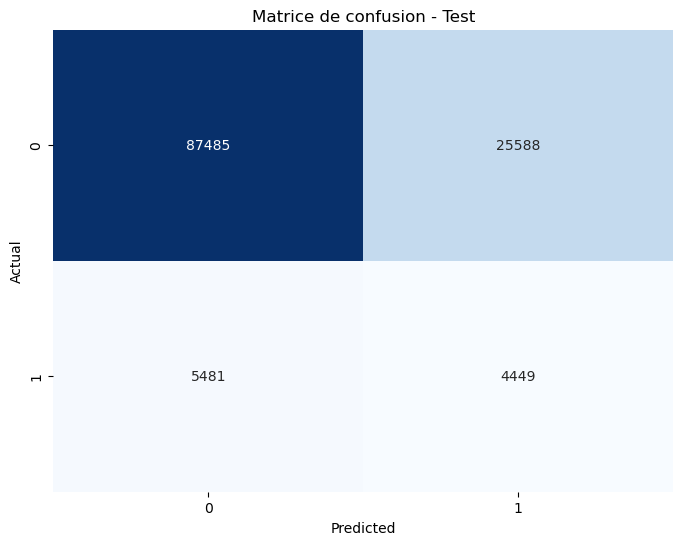

In [155]:
plot_confusion_matrix(y_test, y_test_pred_xgb, 'Matrice de confusion - Test')


## Le meilleur modèle 

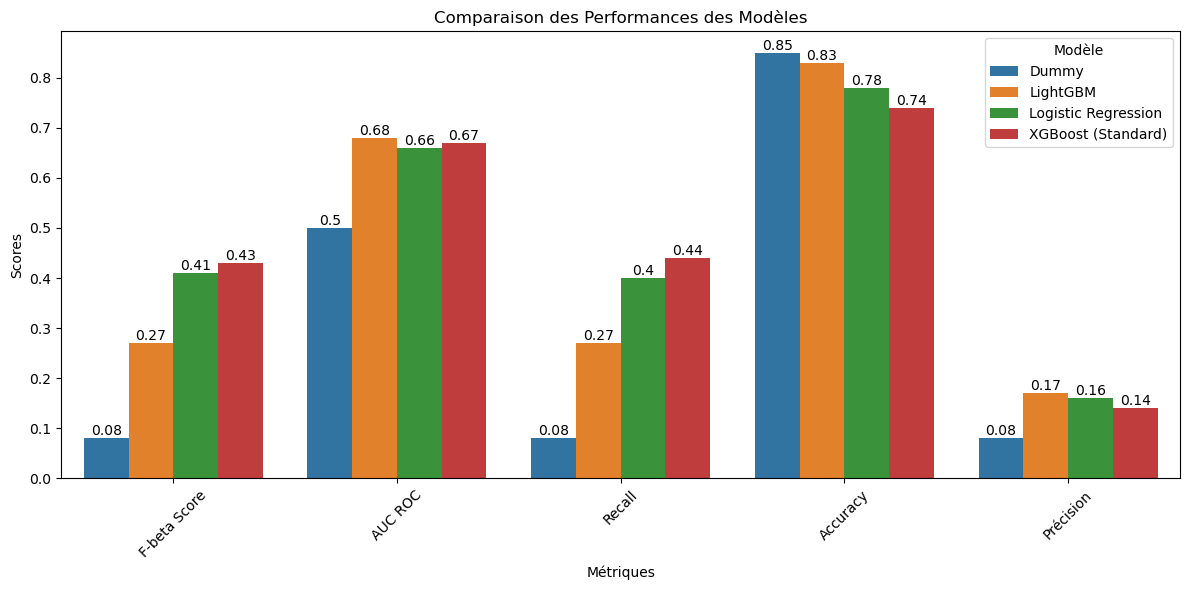

In [157]:
# Données des résultats des modèles, incluant XGBoost avec seuil optimisé
data = {
    'Modèle': ['Dummy', 'LightGBM','Logistic Regression', 'XGBoost (Standard)',],
    'F-beta Score': [0.08, 0.27, 0.41,  0.43],
    'AUC ROC': [0.50, 0.68, 0.66, 0.67],
    'Recall': [0.08, 0.27, 0.40, 0.44],
    'Accuracy': [0.85, 0.83, 0.78, 0.74],
    'Précision': [0.08, 0.17, 0.16, 0.14]
    
}

# Créer un DataFrame avec les résultats
df_results = pd.DataFrame(data)

# Tracer le graphique de comparaison des performances
plt.figure(figsize=(12, 6))

# Reshaper les données pour Seaborn
df_melt = df_results.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

# Création du barplot
sns.barplot(x='Métrique', y='Score', hue='Modèle', data=df_melt)

# Ajouter les scores sur les barres
for i, bar in enumerate(plt.gca().patches):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Position x
        bar.get_height(),  # Position y (hauteur de la barre)
        round(bar.get_height(), 2),  # Le score affiché
        ha='center', va='bottom', fontsize=10  # Style du texte
    )

# Ajouter les étiquettes et titre
plt.title("Comparaison des Performances des Modèles")
plt.xlabel("Métriques")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(title="Modèle")

# Afficher le graphique
plt.tight_layout()
plt.show()

### Amelioration resultats modèle XGBoost

C:\anacond\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anacond\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\anacond\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


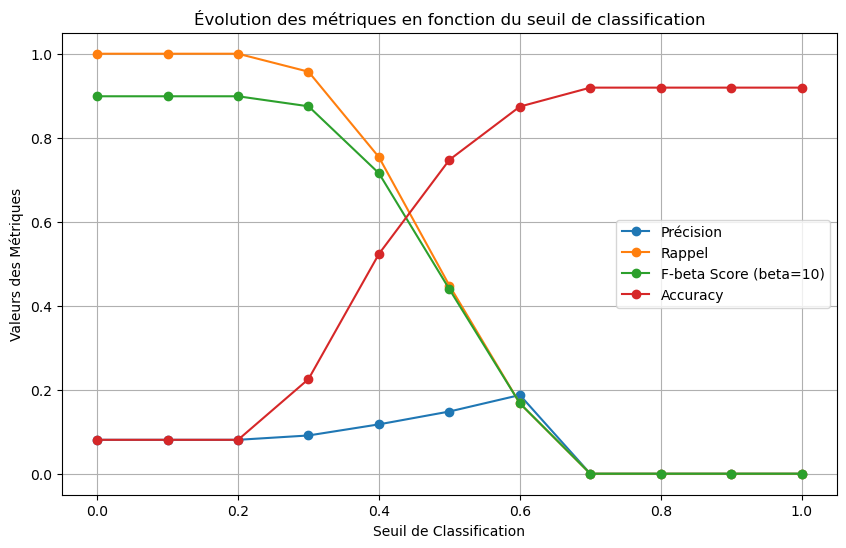

In [158]:
# Calcul des probabilités de prédiction pour chaque exemple
y_pred_prob = best_xgb_model.predict_proba(X_test)[:, 1]

# Liste des seuils
thresholds = np.arange(0.0, 1.1, 0.1)

# Listes pour stocker les métriques en fonction du seuil
precision_list = []
recall_list = []
fbeta_list = []
accuracy_list = []

# Calcul des métriques pour chaque seuil
for threshold in thresholds:
    # Appliquer le seuil pour prédire les classes
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)
    
    # Calcul des métriques
    precision_list.append(precision_score(y_test, y_pred_threshold))
    recall_list.append(recall_score(y_test, y_pred_threshold))
    fbeta_list.append(fbeta_score(y_test, y_pred_threshold, beta=10))  # Utilisation de F-beta avec beta=10
    accuracy_list.append(accuracy_score(y_test, y_pred_threshold))

# Création du graphique
plt.figure(figsize=(10, 6))

plt.plot(thresholds, precision_list, label='Précision', marker='o')
plt.plot(thresholds, recall_list, label='Rappel', marker='o')
plt.plot(thresholds, fbeta_list, label='F-beta Score (beta=10)', marker='o')
plt.plot(thresholds, accuracy_list, label='Accuracy', marker='o')

plt.xlabel('Seuil de Classification')
plt.ylabel('Valeurs des Métriques')
plt.title('Évolution des métriques en fonction du seuil de classification')
plt.legend()
plt.grid(True)
plt.show()

+ Analyse du seuil optimal :

- Rappel élevé  : Pour minimiser les FN, le rappel doit être élevé, car il capte la capacité du modèle à identifier correctement tous les positifs. Le rappel est maximal pour un seuil de 0 et diminue rapidement après 0,4.

- Précision et rappel : La précision et le rappel sont généralement en tension. Un seuil bas conduit à un rappel élevé, mais à une précision plus faible (car plus de faux positifs sont prédits).

- F-beta (vert) : Le F-beta score avec beta=10 pondère beaucoup plus le rappel que la précision, ce qui est exactement en ligne avec votre objectif de minimiser les FN. Le F-beta score est maximisé autour du seuil de 0,1 à 0,4.

- Accuracy (rouge) : Cette métrique n'est pas aussi pertinente dans ce cas, car elle ne pondère pas spécifiquement les FN par rapport aux FP.

In [ ]:
# Calculer les scores F-beta pour différents seuils
thresholds = np.linspace(0.0, 1.0, 101)  # Pas de 0,01
fbeta_scores = []
y_scores = best_xgb_model.predict_proba(X_test)[:, 1]

for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    fbeta_value = fbeta_score(y_test, y_pred, beta=10)
    fbeta_scores.append(fbeta_value)

# Fixer le seuil optimal à 0.4
optimal_threshold = 0.4
optimal_fbeta_score = fbeta_scores[np.argmin(np.abs(thresholds - optimal_threshold))]

# Tracer le graphique du F-beta Score en fonction du seuil de classification
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fbeta_scores, marker='o')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Seuil fixé à: {optimal_threshold:.2f}', lw=2)
plt.xlabel('Seuil de classification')
plt.ylabel('F-beta Score')
plt.title('F-beta Score en fonction du seuil de classification')
plt.legend()
plt.grid(True)
plt.show()

print(f"Seuil optimal fixé : {optimal_threshold}")
print(f"F-beta Score à ce seuil : {optimal_fbeta_score}")

# Enregistrer le seuil optimal dans une exécution imbriquée dans MLflow
with mlflow.start_run(nested=True):
    mlflow.log_param("optimal_threshold", optimal_threshold)

+ Le seuil 0.4 ce seuil maximisera le rappel, minimisant ainsi le nombre de faux négatifs, tout en acceptant quelques faux positifs supplémentaires.

notre objectif est de minimiser les pertes en capital, qui est 10 fois plus coûteux que le manque à gagner dû aux faux positifs.

In [159]:
with open('optimal_threshold.pkl', 'wb') as file:
    pickle.dump(optimal_threshold, file)

In [160]:
# Appliquer le meilleur seuil sur les prédictions du jeu de test
y_test_pred_optimal = (y_test_prob_xgb >= optimal_threshold).astype(int)

In [161]:
# Calculer les métriques sur les prédictions du jeu de test avec le seuil optimisé
fbeta_test_optimal = fbeta_score(y_test, y_test_pred_optimal, beta=10)
auc_test_optimal = roc_auc_score(y_test, y_test_prob_xgb)
recall_test_optimal = recall_score(y_test, y_test_pred_optimal)
precision_test_optimal = precision_score(y_test, y_test_pred_optimal)
accuracy_test_optimal = accuracy_score(y_test, y_test_pred_optimal)

In [162]:
# Afficher les résultats
print(f"F-beta Score optimal sur le jeu de test : {fbeta_test_optimal}")
print(f"AUC ROC Score sur le jeu de test : {auc_test_optimal}")
print(f"Recall optimal sur le jeu de test : {recall_test_optimal}")
print(f"Precision optimale sur le jeu de test : {precision_test_optimal}")
print(f"Accuracy optimale sur le jeu de test : {accuracy_test_optimal}")

# Enregistrer les métriques optimisées dans MLflow
mlflow.log_metric("fbeta_test_optimal", fbeta_test_optimal)
mlflow.log_metric("auc_test_optimal", auc_test_optimal)
mlflow.log_metric("recall_test_optimal", recall_test_optimal)
mlflow.log_metric("precision_test_optimal", precision_test_optimal)
mlflow.log_metric("accuracy_test_optimal", accuracy_test_optimal)

F-beta Score optimal sur le jeu de test : 0.8748250359040906
AUC ROC Score sur le jeu de test : 0.6776452323321078
Recall optimal sur le jeu de test : 0.9572004028197382
Precision optimale sur le jeu de test : 0.09107197608462364
Accuracy optimale sur le jeu de test : 0.22531970764940693


In [163]:
# Terminer toute exécution MLflow active
if mlflow.active_run() is not None:
    mlflow.end_run()

# Initialiser le modèle XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Définir la grille d'hyperparamètres à tester 
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 6, 9]
}

# Créer un pipeline avec SMOTE et XGBoost
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)), ('scaler', preprocessing.StandardScaler()),
    ('xgb', xgb_model)
])

# Initialiser StratifiedKFold pour la validation croisée
skf = StratifiedKFold(n_splits=5)

# Utiliser GridSearchCV avec le score F-beta (beta=10)
fbeta_scorer = make_scorer(fbeta_score, beta=10)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=fbeta_scorer, cv=skf, n_jobs=-1, verbose=1)

# Définir l'expérience MLflow
mlflow.set_experiment("XGBoost_with_SMOTE_Model_No_Validation")

start_time = time.time()  # Début du chronométrage

with mlflow.start_run(run_name='xgb_with_GridSearchCV_and_Fbeta_optimal_threshold'):
    # Enregistrement des hyperparamètres avant GridSearch
    mlflow.log_param("model_type", "XGBoost")

    # Entraîner le modèle avec GridSearchCV
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres
    best_params_xgb = grid_search.best_params_
    print(f"Meilleurs hyperparamètres trouvés : {best_params_xgb}")

    # Meilleur modèle entraîné
    best_xgb_model = grid_search.best_estimator_

    # Enregistrement des hyperparamètres optimisés
    mlflow.log_params(best_params_xgb)

    # Prédictions sur le jeu de test
    y_test_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

    # Appliquer le seuil optimal de 0.4
    optimal_threshold = 0.3
    y_test_pred_optimal = (y_test_prob_xgb >= optimal_threshold).astype(int)

    # Calculer les métriques sur les prédictions du jeu de test avec le seuil optimisé
    fbeta_test_optimal = fbeta_score(y_test, y_test_pred_optimal, beta=10)
    auc_test_optimal = roc_auc_score(y_test, y_test_prob_xgb)
    recall_test_optimal = recall_score(y_test, y_test_pred_optimal)
    precision_test_optimal = precision_score(y_test, y_test_pred_optimal)
    accuracy_test_optimal = accuracy_score(y_test, y_test_pred_optimal)

    # Afficher les résultats des métriques avec le seuil optimisé
    print(f"F-beta Score (optimal threshold) : {fbeta_test_optimal:.4f}")
    print(f"AUC ROC Score (optimal threshold) : {auc_test_optimal:.4f}")
    print(f"Recall (optimal threshold) : {recall_test_optimal:.4f}")
    print(f"Precision (optimal threshold) : {precision_test_optimal:.4f}")
    print(f"Accuracy (optimal threshold) : {accuracy_test_optimal:.4f}")

    # Enregistrement des nouvelles métriques dans MLflow
    mlflow.log_metric("fbeta_test_optimal", fbeta_test_optimal)
    mlflow.log_metric("auc_test_optimal", auc_test_optimal)
    mlflow.log_metric("recall_test_optimal", recall_test_optimal)
    mlflow.log_metric("precision_test_optimal", precision_test_optimal)
    mlflow.log_metric("accuracy_test_optimal", accuracy_test_optimal)

    # Enregistrement du meilleur modèle dans MLflow (modèle temporaire)
    model_uri = "xgb_model_with_SMOTE_and_fbeta_optimal_threshold"
    mlflow.sklearn.log_model(best_xgb_model, model_uri)

    # Enregistrement du modèle dans le Model Registry
    model_name = "XGBoost_with_SMOTE_Model_Fbeta_Optimal_Threshold"
    registered_model_uri = mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_uri}", name=model_name)

end_time = time.time()  # Fin du chronométrage
execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time:.2f} secondes")

# Enregistrer le temps d'exécution dans MLflow
mlflow.log_metric("execution_time", execution_time)

# Créer un DataFrame avec les résultats optimisés
results_optimal = {
    'Dataset': ['Test (Seuil optimisé)'],
    'F-beta Score': [fbeta_test_optimal],
    'AUC ROC Score': [auc_test_optimal],
    'Recall': [recall_test_optimal],
    'Precision': [precision_test_optimal],
    'Accuracy': [accuracy_test_optimal]
}

results_df_optimal = pd.DataFrame(results_optimal)
print(results_df_optimal)

# Finir l'exécution MLflow
mlflow.end_run()

2024/10/17 05:35:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-goose-873 at: http://127.0.0.1:2024/#/experiments/232265814667554854/runs/fd84f113498c4e968631d182a0da0487.
2024/10/17 05:35:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/232265814667554854.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\anacond\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres trouvés : {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
F-beta Score (optimal threshold) : 0.8748
AUC ROC Score (optimal threshold) : 0.6776
Recall (optimal threshold) : 0.9572
Precision (optimal threshold) : 0.0911
Accuracy (optimal threshold) : 0.2253


2024/10/17 05:45:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost_with_SMOTE_Model_Fbeta_Optimal_Threshold' already exists. Creating a new version of this model...
2024/10/17 05:45:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_with_SMOTE_Model_Fbeta_Optimal_Threshold, version 5
Created version '5' of model 'XGBoost_with_SMOTE_Model_Fbeta_Optimal_Threshold'.
2024/10/17 05:45:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_with_GridSearchCV_and_Fbeta_optimal_threshold at: http://127.0.0.1:2024/#/experiments/232265814667554854/runs/f8dda43108674659b4acb798dfb3fad6.
2024/10/17 05:45:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:2024/#/experiments/232265814667554854.
2024/10/17 05:45:50 INF

Temps d'exécution : 601.19 secondes
                 Dataset  F-beta Score  AUC ROC Score  Recall  Precision  \
0  Test (Seuil optimisé)      0.874825       0.677645  0.9572   0.091072   

   Accuracy  
0   0.22532  


In [164]:
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_xgb_model, file)

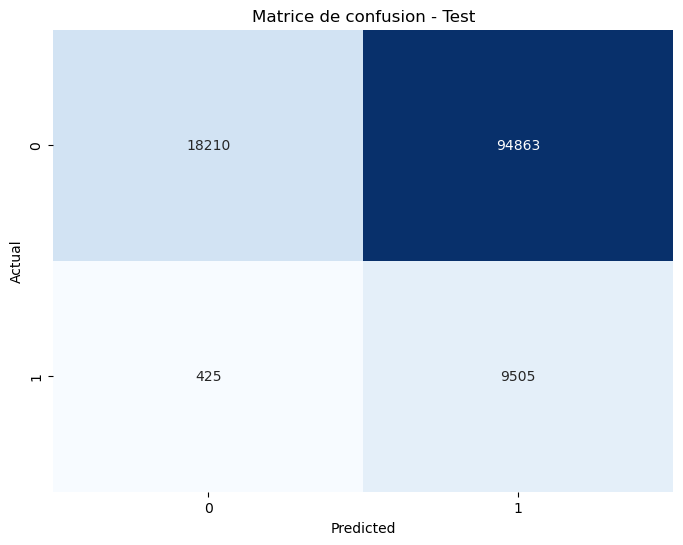

In [165]:
plot_confusion_matrix(y_test, y_test_pred_optimal, 'Matrice de confusion - Test')

## Le meilleur modèle 

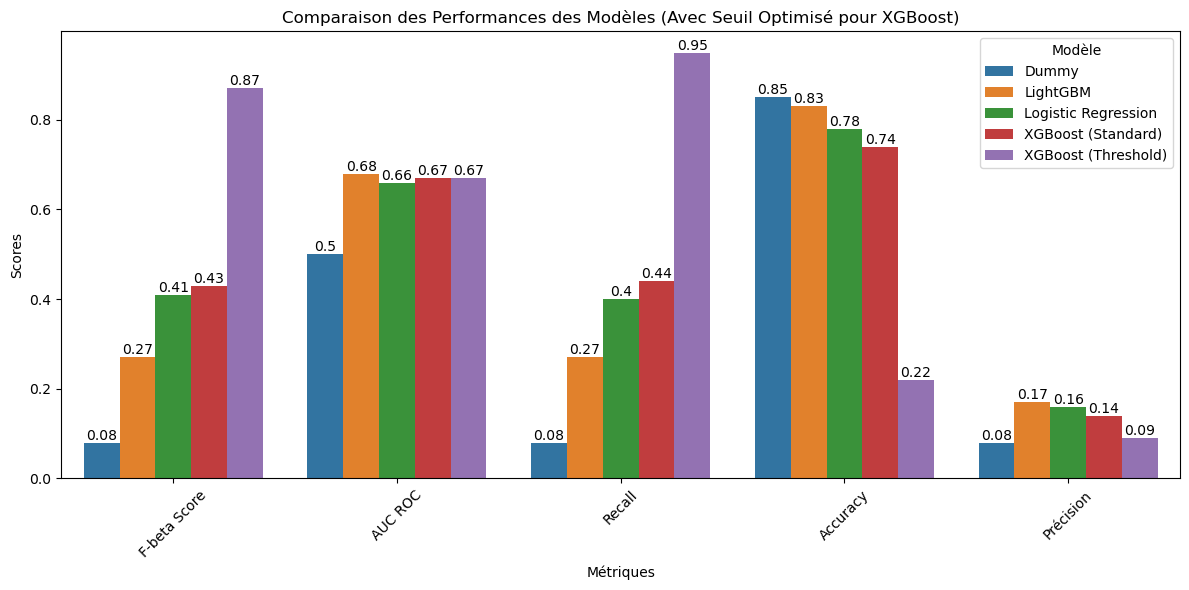

In [167]:
# Données des résultats des modèles, incluant XGBoost avec seuil optimisé
data = {
    'Modèle': ['Dummy', 'LightGBM','Logistic Regression', 'XGBoost (Standard)', 'XGBoost (Threshold)'],
    'F-beta Score': [0.08, 0.27, 0.41,  0.43, 0.87],
    'AUC ROC': [0.50, 0.68, 0.66, 0.67, 0.67],
    'Recall': [0.08, 0.27, 0.40, 0.44, 0.95],
    'Accuracy': [0.85, 0.83, 0.78, 0.74, 0.22],
    'Précision': [0.08, 0.17, 0.16, 0.14, 0.09]
    
}

# Créer un DataFrame avec les résultats
df_results = pd.DataFrame(data)

# Tracer le graphique de comparaison des performances
plt.figure(figsize=(12, 6))

# Reshaper les données pour Seaborn
df_melt = df_results.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

# Création du barplot
sns.barplot(x='Métrique', y='Score', hue='Modèle', data=df_melt)

# Ajouter les scores sur les barres
for i, bar in enumerate(plt.gca().patches):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Position x
        bar.get_height(),  # Position y (hauteur de la barre)
        round(bar.get_height(), 2),  # Le score affiché
        ha='center', va='bottom', fontsize=10  # Style du texte
    )

# Ajouter les étiquettes et titre
plt.title("Comparaison des Performances des Modèles (Avec Seuil Optimisé pour XGBoost)")
plt.xlabel("Métriques")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(title="Modèle")

# Afficher le graphique
plt.tight_layout()
plt.show()

## Importance Globale des Variables

SHAP signifie SHapley Additive exPlanations et utilise l'approche de la théorie des jeux pour expliquer les prédictions des modèles.

SHAP part d'une valeur de base pour la prédiction, basée sur des connaissances préalables, puis essaie les caractéristiques des données une par une pour comprendre l'impact de l'introduction de cette caractéristique sur notre valeur de base afin d'établir la prédiction finale. Il prend même en compte l'ordre d'introduction des caractéristiques ainsi que l'interaction entre les caractéristiques, ce qui nous aide à mieux comprendre les performances du modèle. Au cours de ce processus, il enregistre les valeurs SHAP qui seront utilisées ultérieurement pour tracer et expliquer les prédictions. Ces valeurs SHAP sont générées pour chaque caractéristique des données et montrent généralement leur impact sur la prédiction. SHAP possède de nombreux objets explicatifs qui utilisent différentes approches pour générer des valeurs SHAP en fonction de l'algorithme utilisé.

- Comment interpréter les prédictions à l'aide de SHAP ? Charger la bibliothèque shap (l'importer et l'initialiser). Créer un objet Explainer. Générer des valeurs SHAP pour les exemples de données en utilisant l'objet explainer. Créer diverses visualisations à l'aide de ces valeurs shap pour expliquer les prédictions.

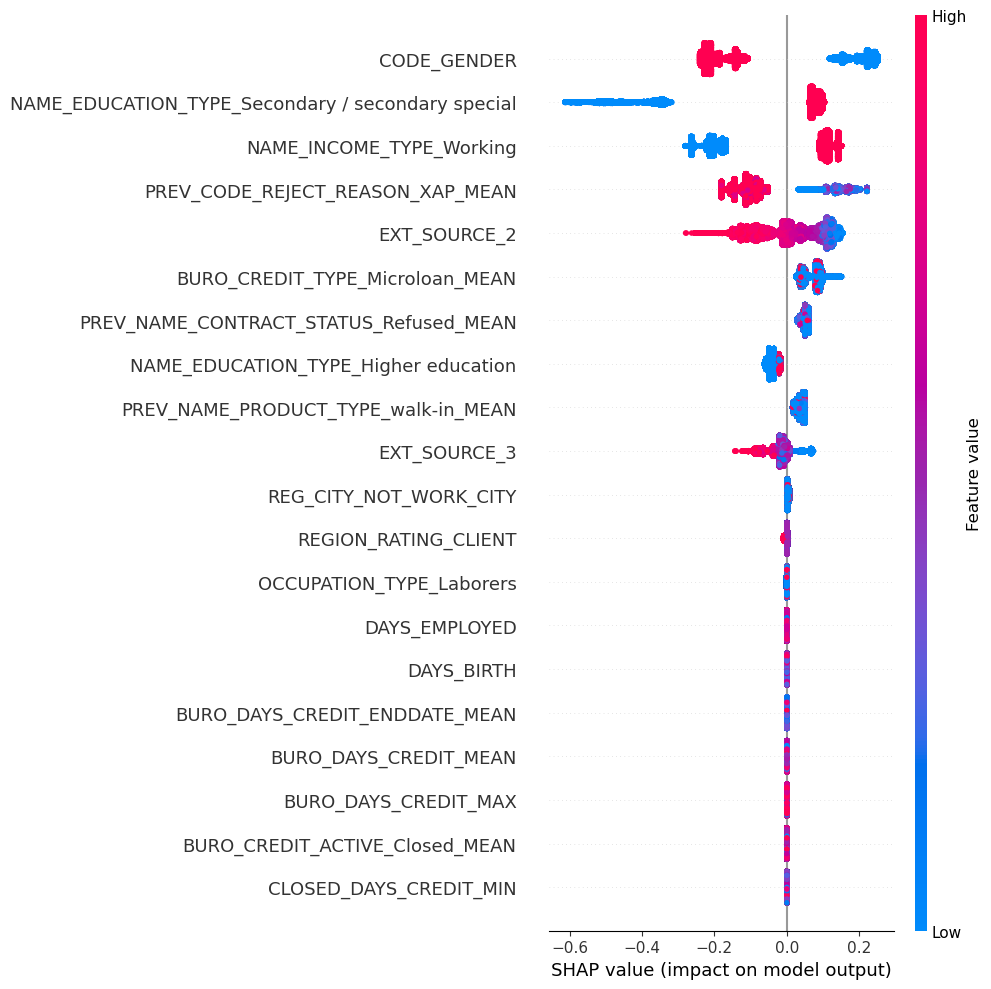

In [168]:
import shap
# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(best_xgb_model.named_steps['xgb'])
# Calculer les valeurs SHAP pour l'ensemble de test
shap_values = explainer.shap_values(X_test)
# Tracer l'importance globale des variables
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=(10,10), title="Graphique des valeurs SHAP")

## Importance Locale des Variables

<Figure size 640x480 with 0 Axes>

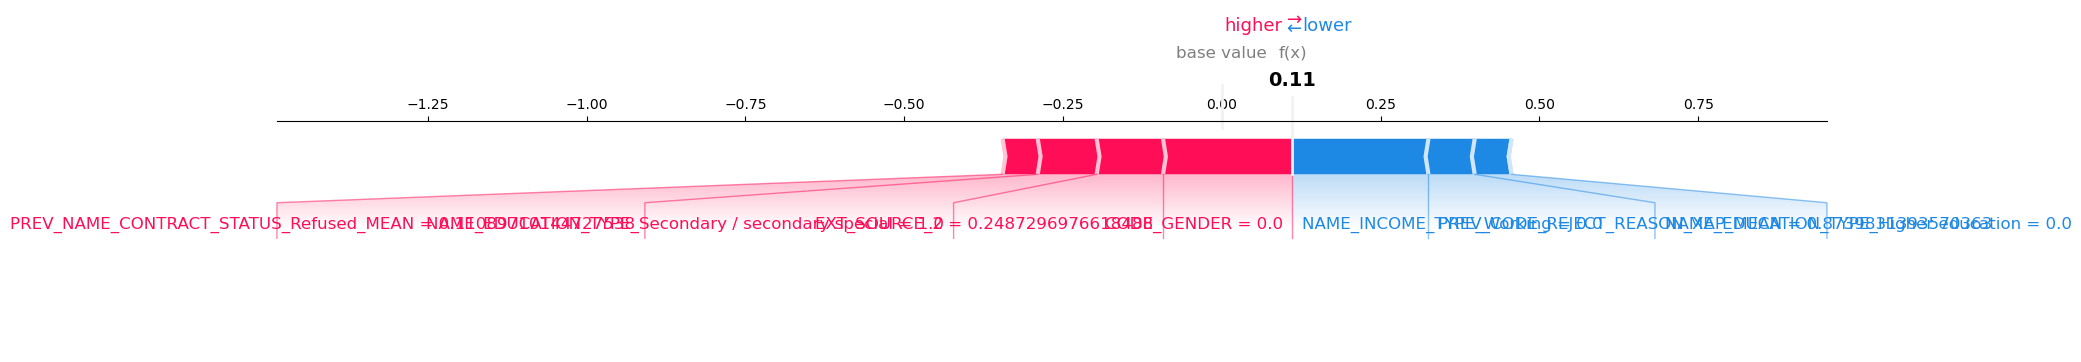

<Figure size 640x480 with 0 Axes>

In [169]:
# Supposons que explainer et shap_values soient déjà définis
# Trier les valeurs SHAP pour obtenir les 4 plus positives et les 4 plus négatives
shap_values_sorted_pos = shap_values[0, :].argsort()[-4:]
shap_values_sorted_neg = shap_values[0, :].argsort()[:4]

# Combiner les indices des valeurs positives et négatives
shap_values_sorted = np.concatenate([shap_values_sorted_pos, shap_values_sorted_neg])

# Créer un nouveau DataFrame avec seulement les variables sélectionnées
X_test_selected = X_test.iloc[0, shap_values_sorted]

# Afficher le graphique SHAP pour les variables sélectionnées
plt.figure()
shap.force_plot(explainer.expected_value, shap_values[0, shap_values_sorted], X_test_selected, matplotlib=True)
plt.savefig("local_shap_importance_selected.png")
mlflow.log_artifact("local_shap_importance_selected.png")
plt.show()